In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# zscore
from scipy.stats import zscore
# scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import *
# partitioning
from sklearn.model_selection import train_test_split
# naive bayes
from sklearn.naive_bayes import GaussianNB, CategoricalNB
# plot things
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve
# pattern mining
from fim import apriori

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve

# plot_cumulative_gain and plot_lift_curve only work in a binary classification case

In [7]:
df_ini = pd.read_csv(r"C:\Users\Steffania\Documents\Projects 1st semester\DM Project\ravdess_dm1_dataset\ravdess_features.csv")

In [8]:
#df = df_ini.copy()
df_clean = df_ini.copy()

In [9]:
nunique = df_clean.nunique()
to_delete = []
for key, value in nunique.items():
    if(value == 1):
        print("To delete: ", key)
        to_delete.append(key)
    if(value > 1 and value < 100):
        print("To evaluate: ", key)

To delete:  modality
To evaluate:  vocal_channel
To evaluate:  emotion
To evaluate:  emotional_intensity
To evaluate:  statement
To evaluate:  repetition
To evaluate:  actor
To evaluate:  sex
To evaluate:  channels
To delete:  sample_width
To delete:  frame_rate
To evaluate:  frame_width
To evaluate:  length_ms
To delete:  stft_max


In [10]:
df_clean = df_clean.drop(columns=to_delete)
df_clean = df_clean.drop(columns=["mean"])

In [11]:
def get_emotion_positivity(x):
    if(x == 'fearful' or x == 'angry' or x =='sad' or x == 'disgust'):
        return -1;
    if(x == 'happy' or x == 'surprised'): # is calm positive?
        return 1;
    return 0;

df_clean["emotion_positivity"] = df_clean["emotion"].map(get_emotion_positivity)

In [12]:
df_clean["length"] = df_clean["length_ms"] / 1000
df_clean["zero_crossings_rate"] = df_clean["zero_crossings_sum"] / df_clean["length"]
df_clean = df_clean.drop(columns=["length_ms","zero_crossings_sum"])
df_clean['statement'] = df_clean['statement'].replace(['Dogs are sitting by the door'], 'S1')
df_clean['statement'] = df_clean['statement'].replace(['Kids are talking by the door'], 'S2')

In [13]:
df = df_clean.copy()

In [14]:
df = df.drop(columns = ["actor", "channels", "frame_width","statement", "repetition","vocal_channel"]).dropna()

## Classification

# Decision trees to predict Emotion

### Partition 

In [15]:
y_e = np.array(df["emotion"]) # <--- this is the variable prediction parameter
df_e = df.drop(columns = ["emotion"])
df_e = pd.get_dummies(df_e, columns=["emotional_intensity", "sex"])

In [16]:
X_e = df_e.values
X_e_train, X_e_test, y_e_train, y_e_test = train_test_split(
    X_e, y_e, test_size=0.3, stratify=y_e, random_state=1
)

In [387]:
# with stratify
print(np.unique(y_e, return_counts=True)[1] / len(y_e))
print(np.unique(y_e_train, return_counts=True)[1] / len(y_e_train))
print(np.unique(y_e_test, return_counts=True)[1] / len(y_e_test))

[0.15158924 0.15403423 0.08312958 0.15403423 0.150978   0.07823961
 0.14914425 0.07885086]
[0.15196507 0.15371179 0.08296943 0.15371179 0.1510917  0.07860262
 0.14934498 0.07860262]
[0.15071283 0.15478615 0.08350305 0.15478615 0.15071283 0.07739308
 0.14867617 0.07942974]


In [17]:
print(X_e_train.shape, X_e_test.shape, y_e_train.shape, y_e_test.shape)

(1145, 29) (491, 29) (1145,) (491,)


### DT 

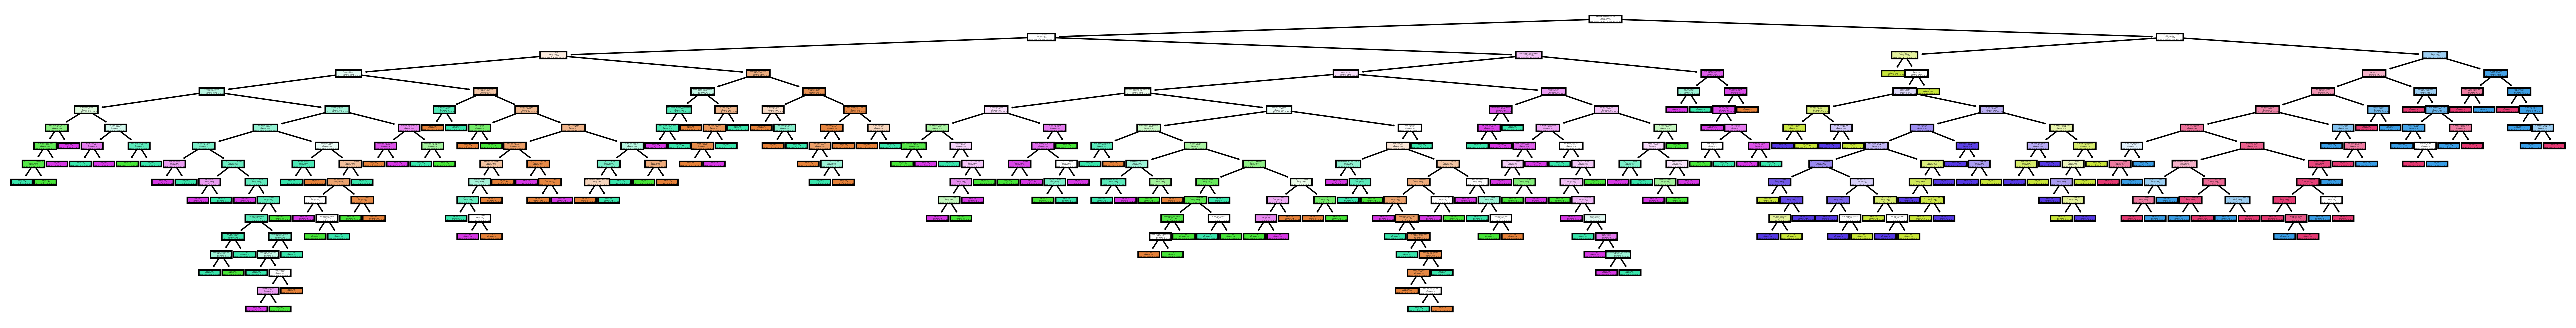

In [19]:
dt = DecisionTreeClassifier()

dt.fit(X_e_train, y_e_train)

plt.figure(figsize=(33, 4), dpi=300)
plot_tree(dt, feature_names=df_e.columns, filled=True)
plt.show()

In [20]:
dt.score(X_e_train, y_e_train)

1.0

### Performance evaluation

In [21]:
y_e_train_pred = dt.predict(X_e_train)
y_e_test_pred = dt.predict(X_e_test)

print(accuracy_score(y_e_train, y_e_train_pred)) #accuracy of the training
print(accuracy_score(y_e_test, y_e_test_pred)) #accuracy of the prediction
print(f1_score(y_e_test, y_e_test_pred, average="macro"))
print(classification_report(y_e_test, y_e_test_pred))

1.0
0.6313645621181263
0.6233520483836861
              precision    recall  f1-score   support

       angry       0.59      0.55      0.57        74
        calm       0.87      0.79      0.83        76
     disgust       0.37      0.37      0.37        41
     fearful       0.49      0.51      0.50        76
       happy       0.83      0.74      0.79        74
     neutral       0.64      0.76      0.70        38
         sad       0.58      0.59      0.59        73
   surprised       0.60      0.72      0.65        39

    accuracy                           0.63       491
   macro avg       0.62      0.63      0.62       491
weighted avg       0.64      0.63      0.63       491



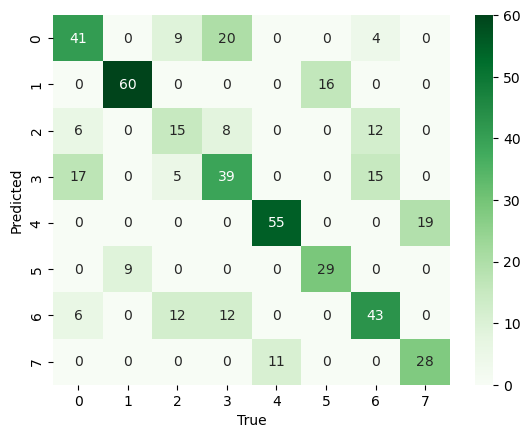

In [22]:
cf = confusion_matrix(y_e_test, y_e_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [23]:
y_e_test_pred_proba = dt.predict_proba(X_e_test)

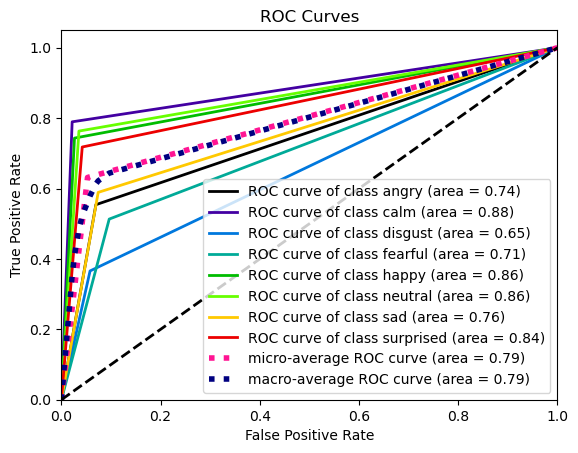

0.7882899218172366


In [24]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
plot_roc(y_e_test, dt.predict_proba(X_e_test))
plt.show()
print(roc_auc_score(y_e_test, y_e_test_pred_proba, multi_class="ovr", average="macro"))

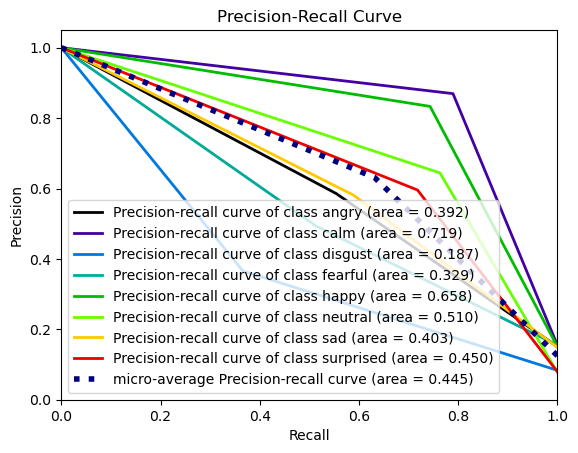

In [25]:
plot_precision_recall(y_e_test, dt.predict_proba(X_e_test))
plt.show()

### Cross-validation 

In [26]:
from sklearn.model_selection import cross_val_score

In [27]:
max_depth = 5
dt = DecisionTreeClassifier(max_depth=max_depth)
scores = cross_val_score(dt, X_e_train, y_e_train, cv=5)
cross_val_score(dt, X_e_train, y_e_train, cv=5)

array([0.58078603, 0.59825328, 0.58951965, 0.65065502, 0.61135371])

In [28]:
scores
#why the scores change in each iteration, 
#and scores and the last line of code of the previous cell are not the same?

array([0.5720524 , 0.59825328, 0.58951965, 0.65502183, 0.60262009])

### DT hyperparameters 

In [29]:
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std()))

Accuracy: 0.6035 (+/- 0.03)


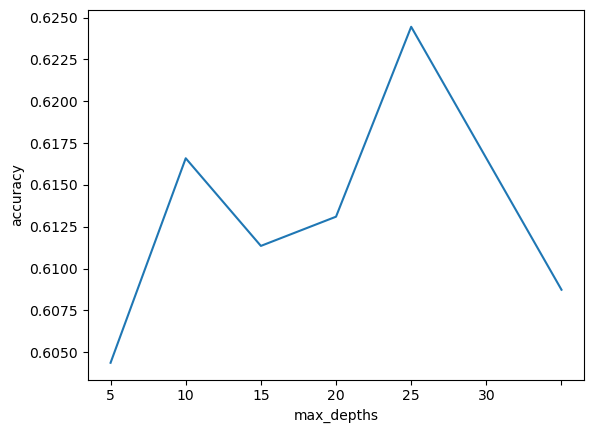

In [30]:
max_depths = [5, 10, 15, 20, 25, 30, None]
scores = list()
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    scores.append(cross_val_score(dt, X_e_train, y_e_train, cv=5).mean())
plt.plot(scores)
plt.xticks(range(len(max_depths)), max_depths)
plt.xlabel("max_depths")
plt.ylabel("accuracy")
plt.show()

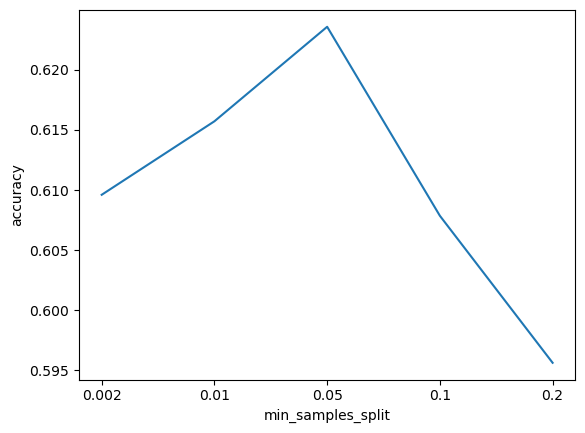

In [31]:
min_samples_splits = [0.002, 0.01, 0.05, 0.1, 0.2]
scores = list()
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    scores.append(cross_val_score(dt, X_e_train, y_e_train, cv=5).mean())
plt.plot(scores)
plt.xticks(range(len(min_samples_splits)), min_samples_splits)
plt.xlabel("min_samples_split")
plt.ylabel("accuracy")
plt.show()

### Grid Search

In [32]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [45]:
param_grid = {
    "min_samples_split": [0.002, 0.01, 0.05, 0.1, 0.2],
    "min_samples_leaf": [0.002, 0.01, 0.05, 0.1, 0.2],
    "max_depth": [5, 10, 15, 20, 25, 30, None],
}

grid = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1),
    n_jobs=-1,
    refit=True,
)

In [46]:
%%time
grid.fit(X_e_train, y_e_train)

Wall time: 24.8 s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=1),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20, 25, 30, None],
                         'min_samples_leaf': [0.002, 0.01, 0.05, 0.1, 0.2],
                         'min_samples_split': [0.002, 0.01, 0.05, 0.1, 0.2]})

In [47]:
clf = grid.best_estimator_

In [48]:
print(grid.best_params_, grid.best_score_)

{'max_depth': 10, 'min_samples_leaf': 0.002, 'min_samples_split': 0.01} 0.6327510917030568


In [49]:
clf.score(X_e_test, y_e_test)

0.6537678207739308

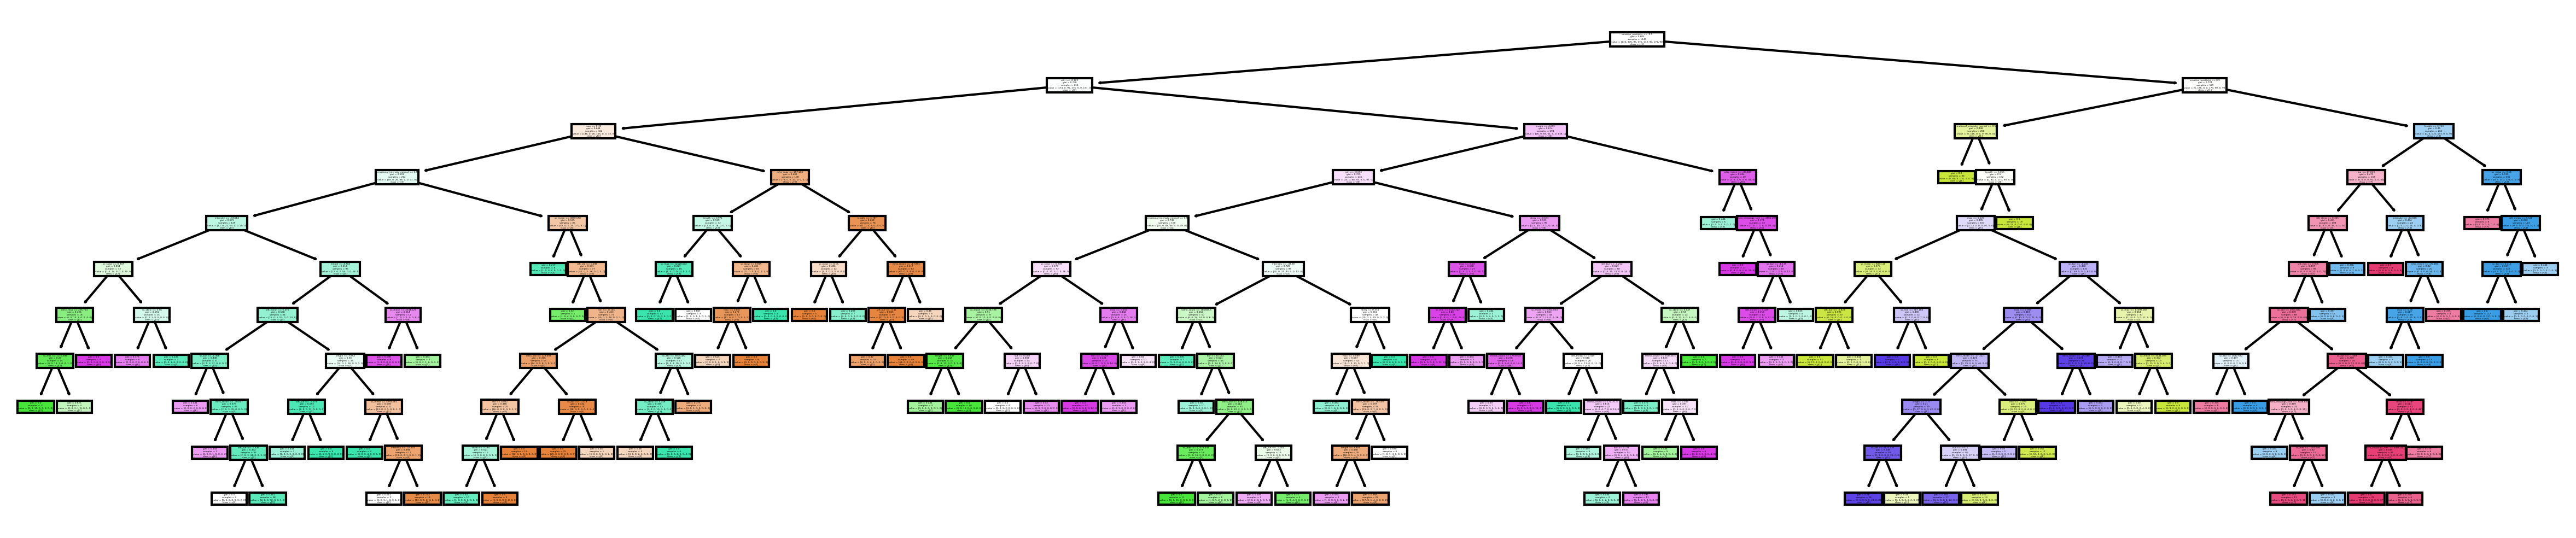

In [50]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=0.01, min_samples_leaf= 0.002)
dt.fit(X_e_train, y_e_train)
plt.figure(figsize=(20, 4), dpi=300)
plot_tree(dt, feature_names=df_e.columns, class_names=True, filled=True)
plt.show()

#### changing criterions

In [39]:
from scipy.stats import uniform, randint, loguniform

In [51]:
%%time
param_grid = {
    "min_samples_split": loguniform(1e-2, 1e0),
    "min_samples_leaf": uniform(0.001, 0.2),
    "max_depth": randint(2, 200),
    "criterion": ["gini", "entropy", "log_loss"],
}
grid = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    n_iter=200,
)
grid.fit(X_e_train, y_e_train)
clf = grid.best_estimator_

Wall time: 32.8 s


In [52]:
print(grid.best_params_, grid.best_score_)

{'criterion': 'entropy', 'max_depth': 176, 'min_samples_leaf': 0.0015803323442854502, 'min_samples_split': 0.01436550127411131} 0.6273362445414847


In [42]:
clf.score(X_e_test, y_e_test)

0.6130346232179226

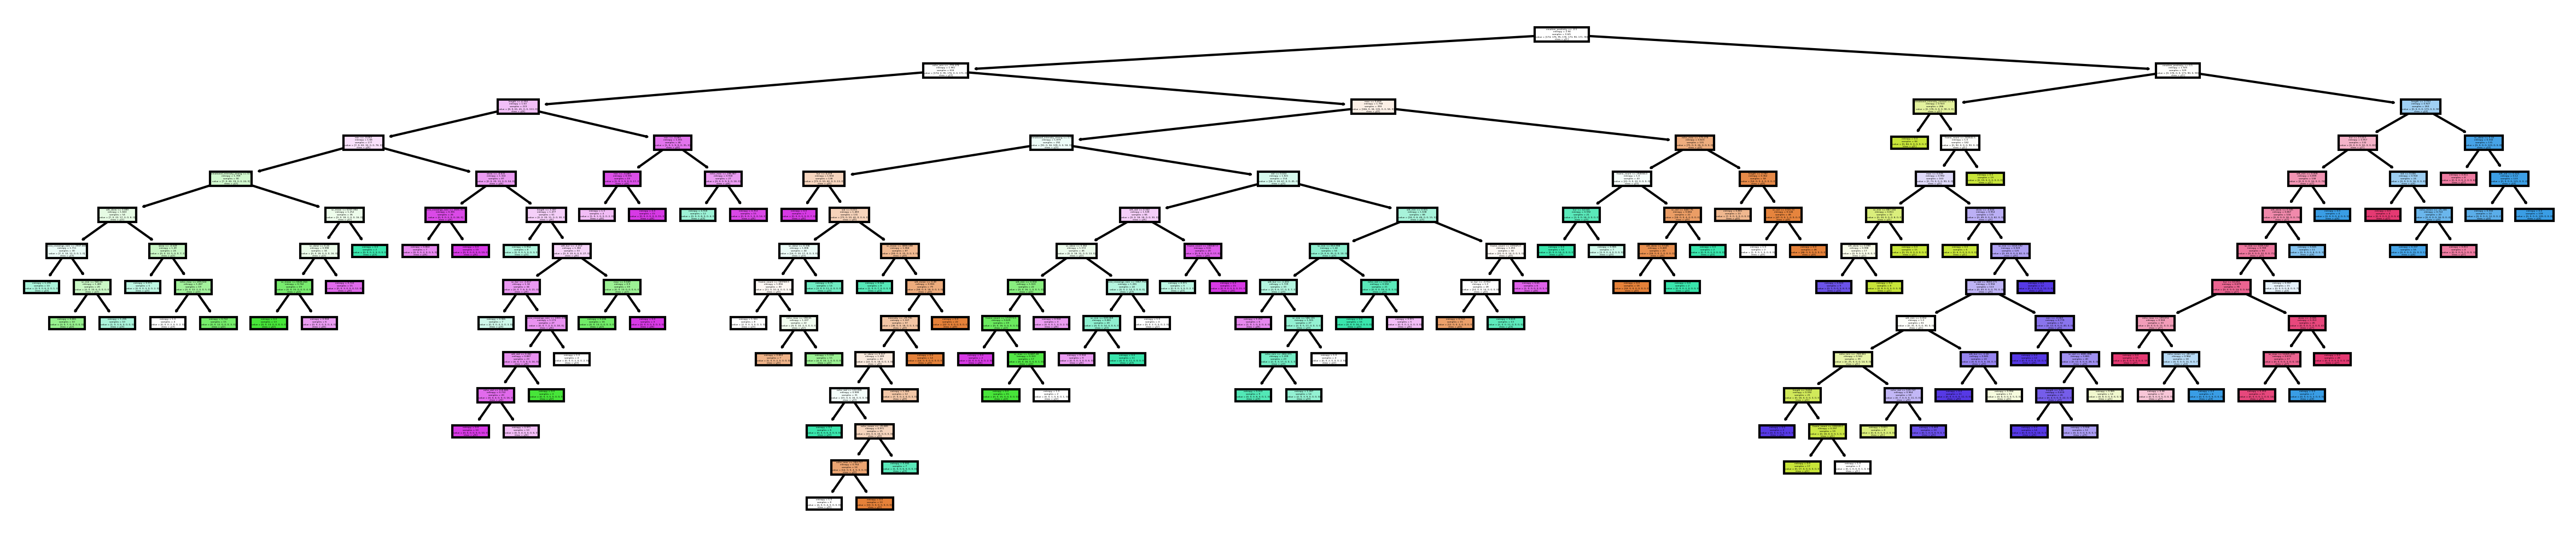

In [53]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=176, min_samples_split=0.01436550127411131, min_samples_leaf=0.0015803323442854502)
dt.fit(X_e_train, y_e_train)
plt.figure(figsize=(20, 4), dpi=300)
plot_tree(dt,feature_names=df_e.columns, class_names=True, filled=True)
plt.show()

### Performance evaluation with the optimal parameters

In [41]:
y_e_train_pred = dt.predict(X_e_train)
print(accuracy_score(y_e_train, y_e_train_pred))

0.5903930131004367


In [43]:
y_e_test_pred = dt.predict(X_e_test)
print(accuracy_score(y_e_test, y_e_test_pred))
print(f1_score(y_e_test, y_e_test_pred, average="macro"))

0.5865580448065173
0.48597627957142275


In [44]:
print(classification_report(y_e_test, y_e_test_pred))

              precision    recall  f1-score   support

       angry       0.65      0.49      0.56        74
        calm       0.67      1.00      0.80        76
     disgust       0.00      0.00      0.00        41
     fearful       0.35      0.53      0.42        76
       happy       0.94      0.68      0.79        74
     neutral       0.00      0.00      0.00        38
         sad       0.52      0.68      0.59        73
   surprised       0.60      0.92      0.73        39

    accuracy                           0.59       491
   macro avg       0.47      0.54      0.49       491
weighted avg       0.52      0.59      0.54       491



C:\Users\Steffania\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Steffania\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Steffania\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


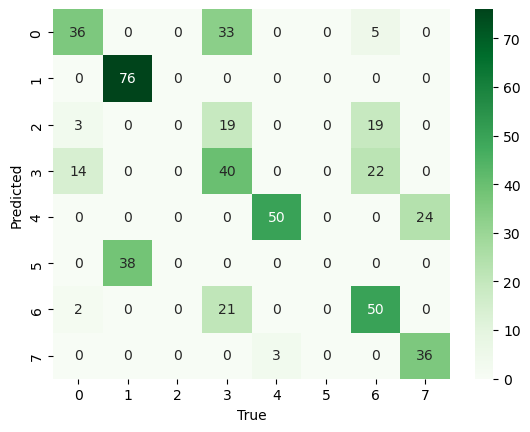

In [151]:
cf = confusion_matrix(y_e_test, y_e_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

<AxesSubplot:>

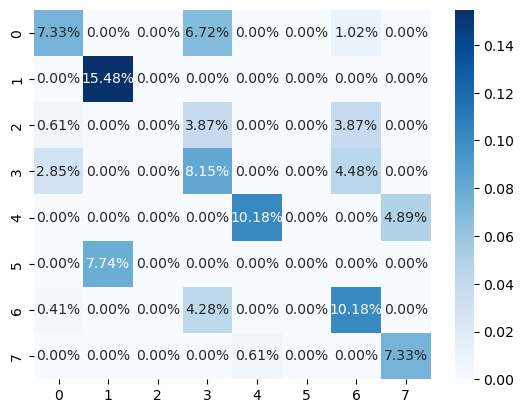

In [152]:
sns.heatmap(cf/np.sum(cf), annot=True, 
            fmt='.2%', cmap='Blues')

In [46]:
y_e_test_pred_proba = dt.predict_proba(X_e_test)

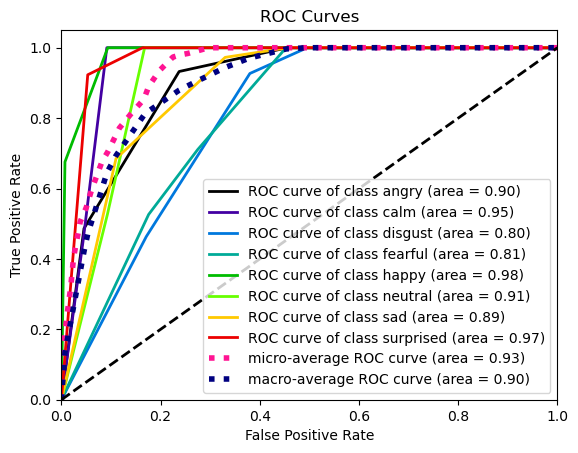

0.9016796249418242


In [47]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
plot_roc(y_e_test, dt.predict_proba(X_e_test))
plt.show()
print(roc_auc_score(y_e_test, y_e_test_pred_proba, multi_class="ovr", average="macro"))

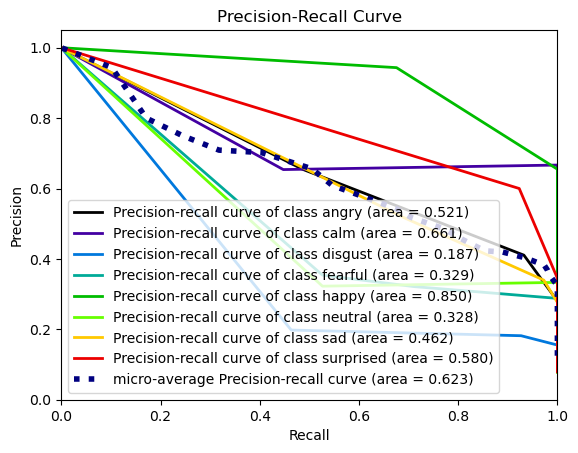

In [48]:
plot_precision_recall(y_e_test, dt.predict_proba(X_e_test))
plt.show()

# Decision trees to predict Sex

In [54]:
y_s = np.array(df["sex"]) # <--- this is the variable prediction parameter
df_s = df.drop(columns = ["sex"])
df_s = pd.get_dummies(df_s, columns=["emotional_intensity", "emotion"])
X_s = df_s.values
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(
    X_s, y_s, test_size=0.3, stratify=y_s, random_state=0
)

In [50]:
df_s.T

0              2              3     \
frame_count                 179379.000000  224224.000000  174575.000000   
intensity                      -36.793432     -32.290737     -49.019839   
mfcc_mean                      -33.485947     -30.532463     -36.059555   
mfcc_std                       134.654860     126.577110     159.725160   
mfcc_min                      -755.223450    -726.060360    -842.946350   
mfcc_max                       171.690920     165.456530     190.036090   
sc_mean                       5792.550744    4830.743037    5376.446478   
sc_std                        3328.055457    3332.131300    4053.663073   
sc_min                           0.000000       0.000000       0.000000   
sc_max                       13541.959028   12007.751173   12048.223893   
sc_kur                          -1.120769      -1.130153      -1.497765   
sc_skew                          0.250940       0.436699       0.098802   
stft_mean                        0.415250       0.379758       0.407277   
stft_std                         0.335533       0.352270       0.360552   
stft_min                         0.000000       0.000000       0.000000   
stft_kur                        -1.215025      -1.242947      -1.445318   
stft_skew                        0.403514       0.470350       0.274756   
std                              0.014482       0.024317       0.003561   
min                             -0.128632      -0.137482      -0.027374   
max                              0.138947       0.166351       0.024078   
kur                              9.406061       4.881241      13.040259   
skew                             0.273153       0.302659      -0.081014   
emotion_positivity              -1.000000       1.000000       1.000000   
length                           3.737000       4.671000       3.637000   
zero_crossings_rate           4547.765587    4008.349390    3194.116030   
emotional_intensity_normal       1.000000       0.000000       1.000000   
emotional_intensity_strong       0.000000       1.000000       0.000000   
emotion_angry                    0.000000       0.000000       0.000000   
emotion_calm                     0.000000       0.000000       0.000000   
emotion_disgust                  0.000000       0.000000       0.000000   
emotion_fearful                  1.000000       0.000000       0.000000   
emotion_happy                    0.000000       1.000000       0.000000   
emotion_neutral                  0.000000       0.000000       0.000000   
emotion_sad                      0.000000       0.000000       0.000000   
emotion_surprised                0.000000       0.000000       1.000000   

                                     4              5              7     \
frame_count                 211411.000000  171371.000000  164965.000000   
intensity                      -31.214503     -36.312244     -49.095042   
mfcc_mean                      -31.405996     -30.500889     -36.048576   
mfcc_std                       122.125824     132.581730     167.652130   
mfcc_min                      -700.702760    -719.165470    -910.497440   
mfcc_max                       161.134000     213.681920     220.383730   
sc_mean                       5146.012474    4251.116912    6085.206268   
sc_std                        3442.724109    3833.178183    3737.829447   
sc_min                           0.000000       0.000000       0.000000   
sc_max                       12025.582707   12063.200741   12000.006162   
sc_kur                          -1.167544      -1.114527      -1.601514   
sc_skew                          0.496066       0.555198      -0.112737   
stft_mean                        0.415974       0.349669       0.487306   
stft_std                         0.350655       0.345256       0.328248   
stft_min                         0.000000       0.000000       0.000000   
stft_kur                        -1.366742      -1.098179      -1.307958   
stft_skew                        0.318926       0.576157     

In [55]:
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(
    X_s, y_s, test_size=0.3, stratify=y_s, random_state=0
)

In [52]:
# with stratify
print(np.unique(y_s, return_counts=True)[1] / len(y_s))
print(np.unique(y_s_train, return_counts=True)[1] / len(y_s_train))
print(np.unique(y_s_test, return_counts=True)[1] / len(y_s_test))

[0.48288509 0.51711491]
[0.48296943 0.51703057]
[0.48268839 0.51731161]


In [56]:
print(X_s_train.shape, X_s_test.shape, y_s_train.shape, y_s_test.shape)

(1145, 35) (491, 35) (1145,) (491,)


In [57]:
%%time
dt.fit(X_s_train, y_s_train)

Wall time: 39.9 ms


DecisionTreeClassifier(criterion='entropy', max_depth=176,
                       min_samples_leaf=0.0015803323442854502,
                       min_samples_split=0.01436550127411131)

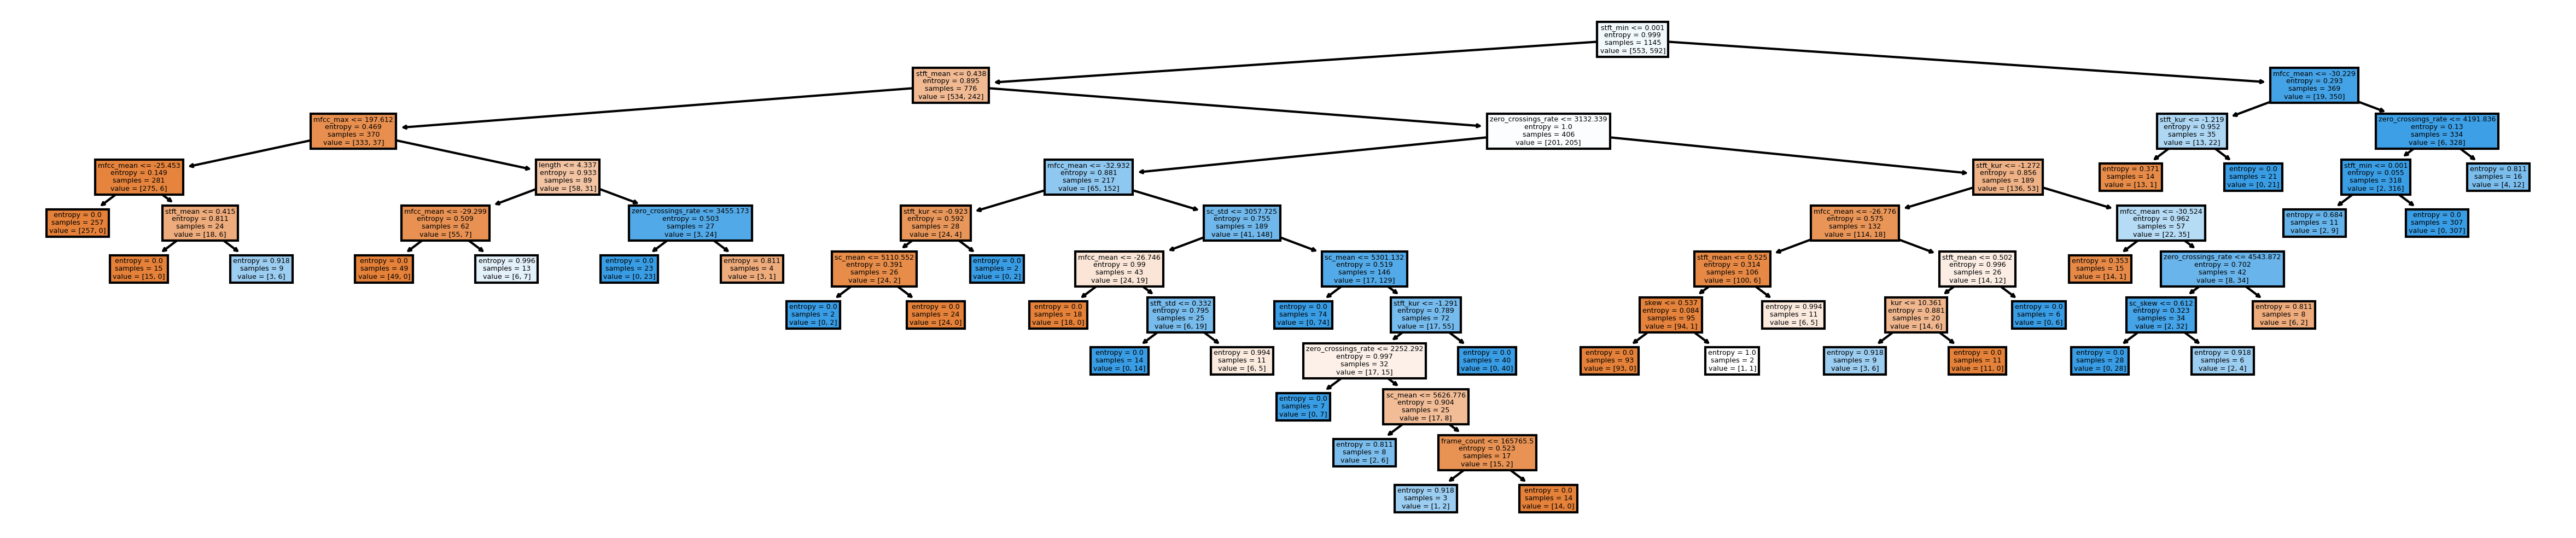

In [58]:
plt.figure(figsize=(20, 4), dpi=300)
plot_tree(dt, feature_names=df_s.columns, filled=True)
plt.show()

In [59]:
dt.score(X_s_train, y_s_train)

0.965938864628821

In [60]:
y_s_train_pred = dt.predict(X_s_train)
print(accuracy_score(y_s_train, y_s_train_pred))

0.965938864628821


In [61]:
y_s_test_pred = dt.predict(X_s_test)
print(accuracy_score(y_s_test, y_s_test_pred))
print(f1_score(y_s_test, y_s_test_pred, average="macro"))

0.9042769857433809
0.904047732895366


In [62]:
print(classification_report(y_s_test, y_s_test_pred))

              precision    recall  f1-score   support

           F       0.91      0.89      0.90       237
           M       0.90      0.92      0.91       254

    accuracy                           0.90       491
   macro avg       0.90      0.90      0.90       491
weighted avg       0.90      0.90      0.90       491



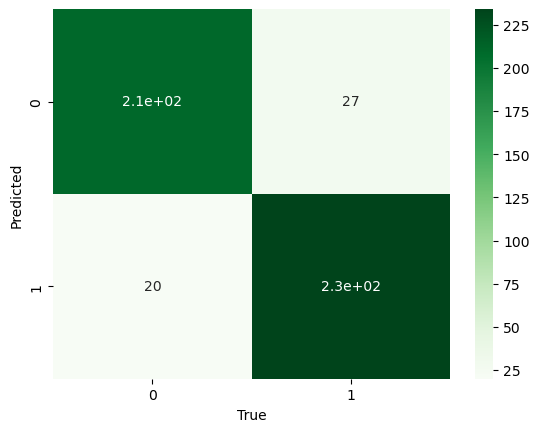

In [63]:
cf = confusion_matrix(y_s_test, y_s_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [64]:
y_s_test_pred_proba = dt.predict_proba(X_s_test)

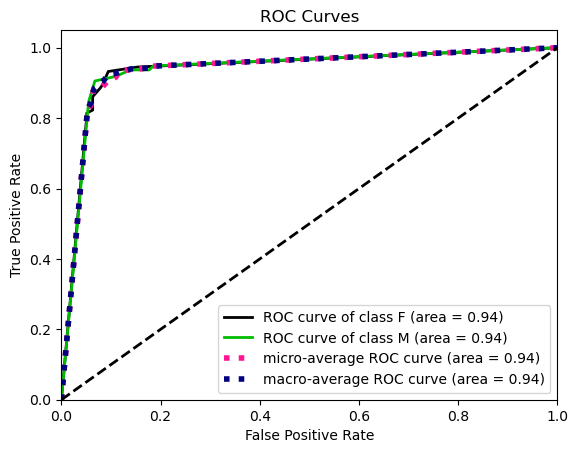

0.9370244858633178


In [65]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
plot_roc(y_s_test, dt.predict_proba(X_s_test))
plt.show()
print(roc_auc_score(y_s_test, y_s_test_pred_proba[:,1], multi_class="ovr", average="macro"))

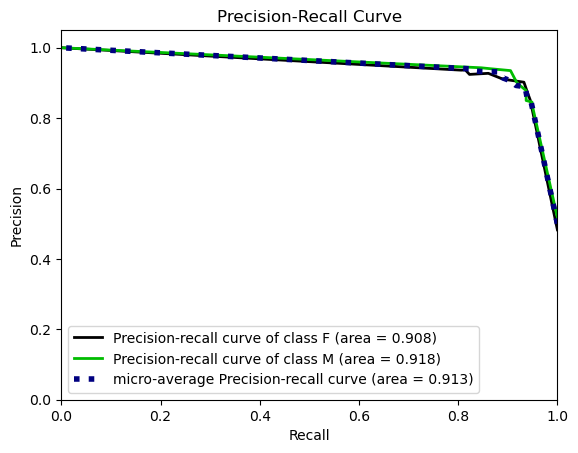

In [66]:
plot_precision_recall(y_s_test, dt.predict_proba(X_s_test))
plt.show()

### Cross-validation 

In [67]:
max_depth = 5
dt = DecisionTreeClassifier(max_depth=max_depth)
scores_s = cross_val_score(dt, X_s_train, y_s_train, cv=5)
cross_val_score(dt, X_s_train, y_s_train, cv=5)

array([0.90393013, 0.89519651, 0.89956332, 0.90393013, 0.84716157])

In [68]:
scores_s
#why the scores change in each iteration, 
#and scores and the last line of code of the previous cell are not the same?

array([0.89956332, 0.88646288, 0.90393013, 0.90829694, 0.86026201])

### DT hyperparameters 

In [69]:
print('Accuracy: %0.4f (+/- %0.2f)' % (scores_s.mean(), scores_s.std()))

Accuracy: 0.8917 (+/- 0.02)


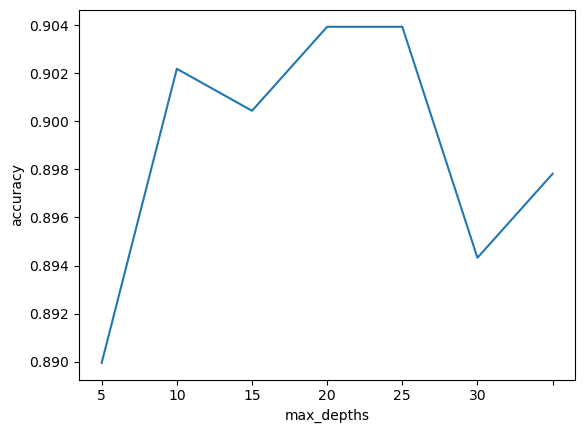

In [70]:
max_depths = [5, 10, 15, 20, 25, 30, None]
scores_s = list()
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    scores_s.append(cross_val_score(dt, X_s_train, y_s_train, cv=5).mean())
plt.plot(scores_s)
plt.xticks(range(len(max_depths)), max_depths)
plt.xlabel("max_depths")
plt.ylabel("accuracy")
plt.show()

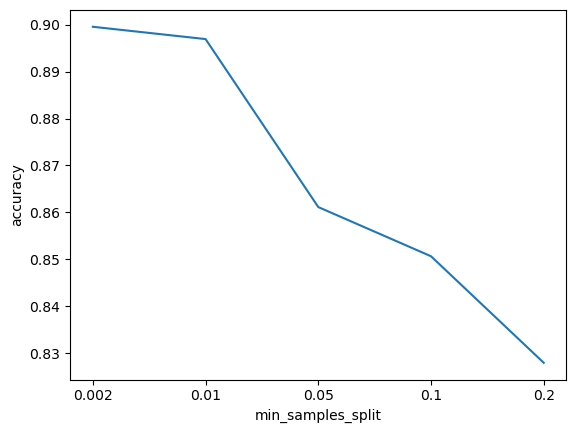

In [71]:
min_samples_splits = [0.002, 0.01, 0.05, 0.1, 0.2]
scores_s = list()
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    scores_s.append(cross_val_score(dt, X_s_train, y_s_train, cv=5).mean())
plt.plot(scores_s)
plt.xticks(range(len(min_samples_splits)), min_samples_splits)
plt.xlabel("min_samples_split")
plt.ylabel("accuracy")
plt.show()

### Grid Search

In [72]:
param_grid = {
    "min_samples_split": [0.002, 0.01, 0.05, 0.1, 0.2],
    "min_samples_leaf": [0.002, 0.01, 0.05, 0.1, 0.2],
    "max_depth": [5, 10, 15, 20, 25, 30, None],
}

grid = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0),
    n_jobs=-1,
    refit=True,
)

In [73]:
%%time
grid.fit(X_s_train, y_s_train)

Wall time: 38.5 s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20, 25, 30, None],
                         'min_samples_leaf': [0.002, 0.01, 0.05, 0.1, 0.2],
                         'min_samples_split': [0.002, 0.01, 0.05, 0.1, 0.2]})

In [74]:
clf_s = grid.best_estimator_

In [76]:
print(grid.best_params_, grid.best_score_)

{'max_depth': None, 'min_samples_leaf': 0.002, 'min_samples_split': 0.002} 0.8951965065502182


In [77]:
clf_s.score(X_s_test, y_s_test)

0.9103869653767821

#### changing criterions

In [78]:
%%time
param_grid = {
    "min_samples_split": loguniform(1e-2, 1e0),
    "min_samples_leaf": uniform(0.001, 0.2),
    "max_depth": randint(2, 200),
    "criterion": ["gini", "entropy", "log_loss"],
}
grid = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    n_iter=200,
)
grid.fit(X_s_train, y_s_train)
clf = grid.best_estimator_

Wall time: 31.4 s


In [79]:
print(grid.best_params_, grid.best_score_)

{'criterion': 'log_loss', 'max_depth': 11, 'min_samples_leaf': 0.0026667493688443448, 'min_samples_split': 0.01941735549962831} 0.8971179039301309


In [80]:
clf.score(X_s_test, y_s_test)

0.9063136456211812

### Performance evaluation with the optimal parameters

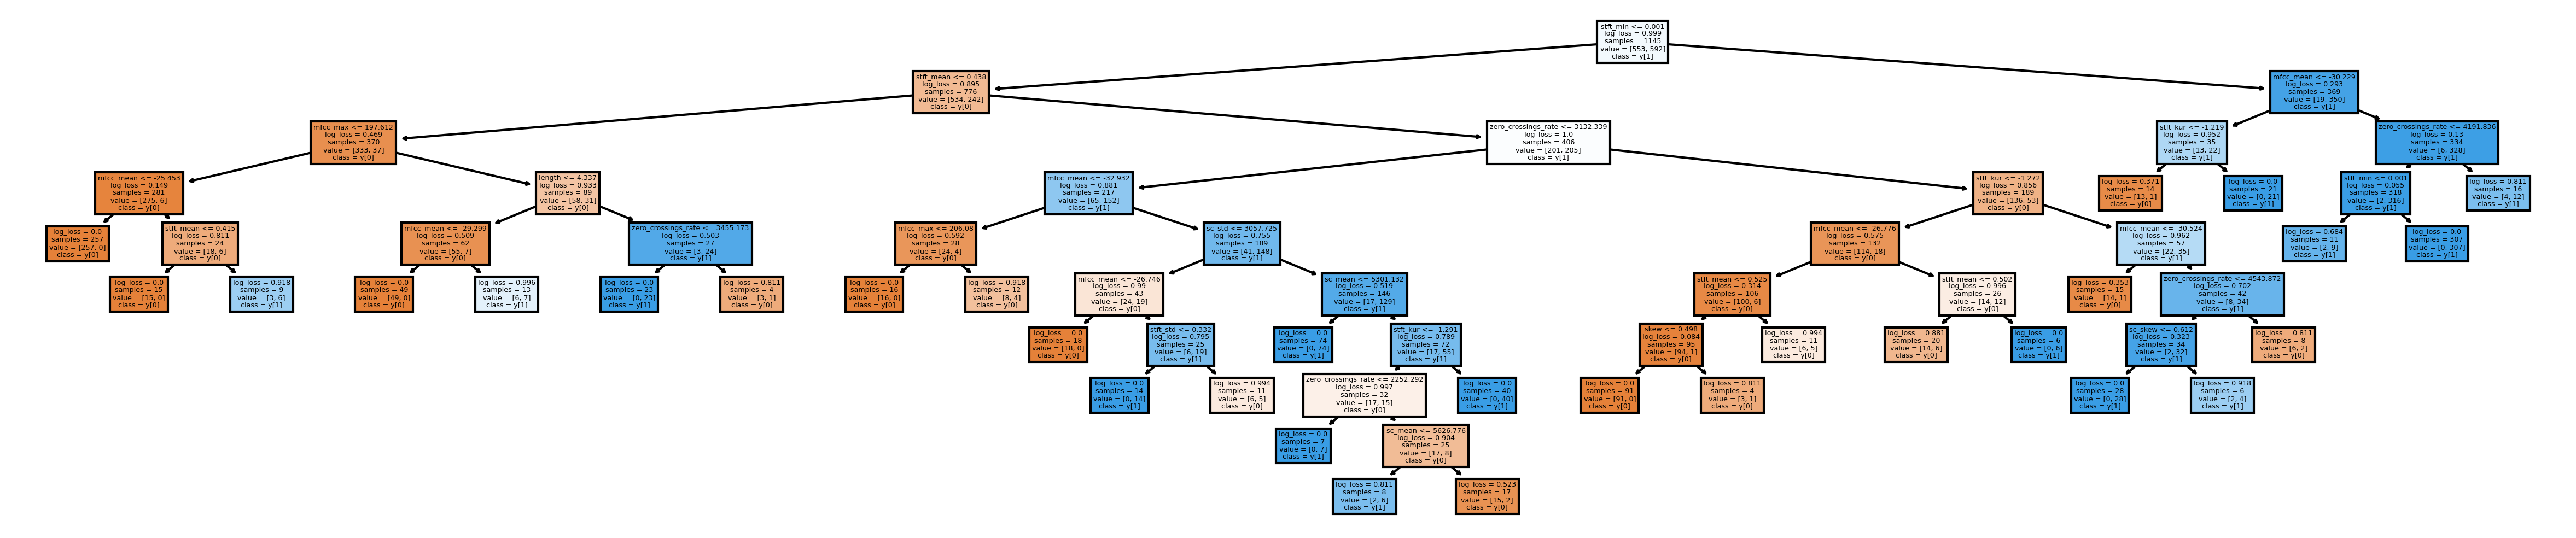

In [81]:
dt = DecisionTreeClassifier(criterion='log_loss', max_depth=11, min_samples_split=0.02, min_samples_leaf=0.003)
dt.fit(X_s_train, y_s_train)
plt.figure(figsize=(20, 4), dpi=300)
plot_tree(dt, feature_names=df_s.columns, class_names= True, filled=True)
plt.show()

In [82]:
y_s_train_pred = dt.predict(X_s_train)
print(accuracy_score(y_s_train, y_s_train_pred))

0.9589519650655022


In [83]:
y_s_test_pred = dt.predict(X_s_test)
print(accuracy_score(y_s_test, y_s_test_pred))
print(f1_score(y_s_test, y_s_test_pred, average="macro"))

0.9063136456211812
0.9061731472249916


In [84]:
print(classification_report(y_s_test, y_s_test_pred))

              precision    recall  f1-score   support

           F       0.91      0.90      0.90       237
           M       0.91      0.91      0.91       254

    accuracy                           0.91       491
   macro avg       0.91      0.91      0.91       491
weighted avg       0.91      0.91      0.91       491



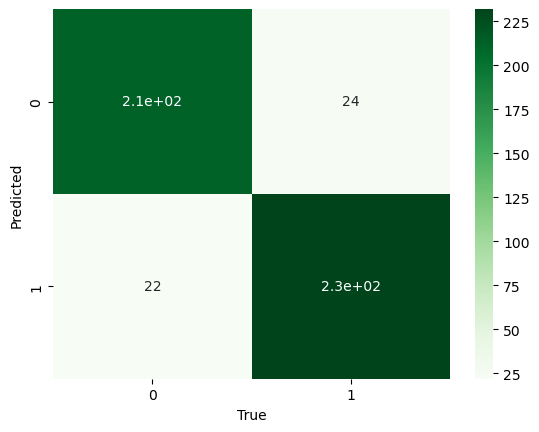

In [85]:
cf = confusion_matrix(y_s_test, y_s_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [86]:
y_s_test_pred_proba = dt.predict_proba(X_s_test)

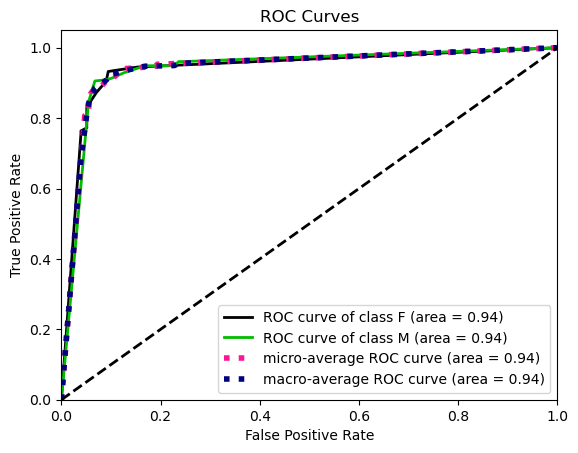

0.9405295857005216


In [87]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
plot_roc(y_s_test, dt.predict_proba(X_s_test))
plt.show()
print(roc_auc_score(y_s_test, y_s_test_pred_proba[:,1], multi_class="ovr", average="macro"))

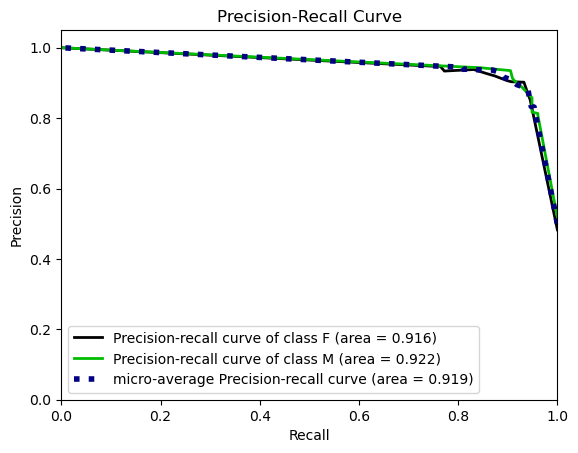

In [88]:
plot_precision_recall(y_s_test, dt.predict_proba(X_s_test))
plt.show()

# Decision trees to predict Emotional intensity

In [89]:
y_ei = np.array(df["emotional_intensity"]) # <--- this is the variable prediction parameter
df_ei = df.drop(columns = ["emotional_intensity"])
df_ei = pd.get_dummies(df_ei, columns=["sex","emotion"])
X_ei = df_ei.values
X_ei_train, X_ei_test, y_ei_train, y_ei_test = train_test_split(
    X_ei, y_ei, test_size=0.3, stratify=y_ei, random_state=0
)

In [84]:
df_ei.T

0              2              3     \
frame_count          179379.000000  224224.000000  174575.000000   
intensity               -36.793432     -32.290737     -49.019839   
mfcc_mean               -33.485947     -30.532463     -36.059555   
mfcc_std                134.654860     126.577110     159.725160   
mfcc_min               -755.223450    -726.060360    -842.946350   
mfcc_max                171.690920     165.456530     190.036090   
sc_mean                5792.550744    4830.743037    5376.446478   
sc_std                 3328.055457    3332.131300    4053.663073   
sc_min                    0.000000       0.000000       0.000000   
sc_max                13541.959028   12007.751173   12048.223893   
sc_kur                   -1.120769      -1.130153      -1.497765   
sc_skew                   0.250940       0.436699       0.098802   
stft_mean                 0.415250       0.379758       0.407277   
stft_std                  0.335533       0.352270       0.360552   
stft_min                  0.000000       0.000000       0.000000   
stft_kur                 -1.215025      -1.242947      -1.445318   
stft_skew                 0.403514       0.470350       0.274756   
std                       0.014482       0.024317       0.003561   
min                      -0.128632      -0.137482      -0.027374   
max                       0.138947       0.166351       0.024078   
kur                       9.406061       4.881241      13.040259   
skew                      0.273153       0.302659      -0.081014   
emotion_positivity       -1.000000       1.000000       1.000000   
length                    3.737000       4.671000       3.637000   
zero_crossings_rate    4547.765587    4008.349390    3194.116030   
sex_F                     1.000000       1.000000       1.000000   
sex_M                     0.000000       0.000000       0.000000   
emotion_angry             0.000000       0.000000       0.000000   
emotion_calm              0.000000       0.000000       0.000000   
emotion_disgust           0.000000       0.000000       0.000000   
emotion_fearful           1.000000       0.000000       0.000000   
emotion_happy             0.000000       1.000000       0.000000   
emotion_neutral           0.000000       0.000000       0.000000   
emotion_sad               0.000000       0.000000       0.000000   
emotion_surprised         0.000000       0.000000       1.000000   

                              4              5              7     \
frame_count          211411.000000  171371.000000  164965.000000   
intensity               -31.214503     -36.312244     -49.095042   
mfcc_mean               -31.405996     -30.500889     -36.048576   
mfcc_std                122.125824     132.581730     167.652130   
mfcc_min               -700.702760    -719.165470    -910.497440   
mfcc_max                161.134000     213.681920     220.383730   
sc_mean                5146.012474    4251.116912    6085.206268   
sc_std                 3442.724109    3833.178183    3737.829447   
sc_min                    0.000000       0.000000       0.000000   
sc_max                12025.582707   12063.200741   12000.006162   
sc_kur                   -1.167544      -1.114527      -1.601514   
sc_skew                   0.496066       0.555198      -0.112737   
stft_mean                 0.415974       0.349669       0.487306   
stft_std                  0.350655       0.345256       0.328248   
stft_min                  0.000000       0.000000       0.000000   
stft_kur                 -1.366742      -1.098179      -1.307958   
stft_skew                 0.318926       0.576157       0.056840   
std                       0.027522       0.015296       0.003526   
min                      -0.192169      -0.122467      -0.027222   
max                       0.242676       0.106171       0.040894   
kur                       7.485109      12.775898      11.289926   
skew                      0.414872       0.028186       0.211353   
emotion_positivit

In [90]:
X_ei_train, X_ei_test, y_ei_train, y_ei_test = train_test_split(
    X_ei, y_ei, test_size=0.3, stratify=y_ei, random_state=1
)

In [86]:
# with stratify
print(np.unique(y_ei, return_counts=True)[1] / len(y_ei))
print(np.unique(y_ei_train, return_counts=True)[1] / len(y_ei_train))
print(np.unique(y_ei_test, return_counts=True)[1] / len(y_ei_test))

[0.53178484 0.46821516]
[0.53187773 0.46812227]
[0.53156823 0.46843177]


In [91]:
print(X_ei_train.shape, X_ei_test.shape, y_ei_train.shape, y_ei_test.shape)

(1145, 35) (491, 35) (1145,) (491,)


In [92]:
%%time
dt.fit(X_ei_train, y_ei_train)

Wall time: 35.3 ms


DecisionTreeClassifier(criterion='log_loss', max_depth=11,
                       min_samples_leaf=0.003, min_samples_split=0.02)

In [114]:
df.columns

Index(['emotion', 'emotional_intensity', 'sex', 'frame_count', 'intensity',
       'mfcc_mean', 'mfcc_std', 'mfcc_min', 'mfcc_max', 'sc_mean', 'sc_std',
       'sc_min', 'sc_max', 'sc_kur', 'sc_skew', 'stft_mean', 'stft_std',
       'stft_min', 'stft_kur', 'stft_skew', 'std', 'min', 'max', 'kur', 'skew',
       'emotion_positivity', 'length', 'zero_crossings_rate'],
      dtype='object')

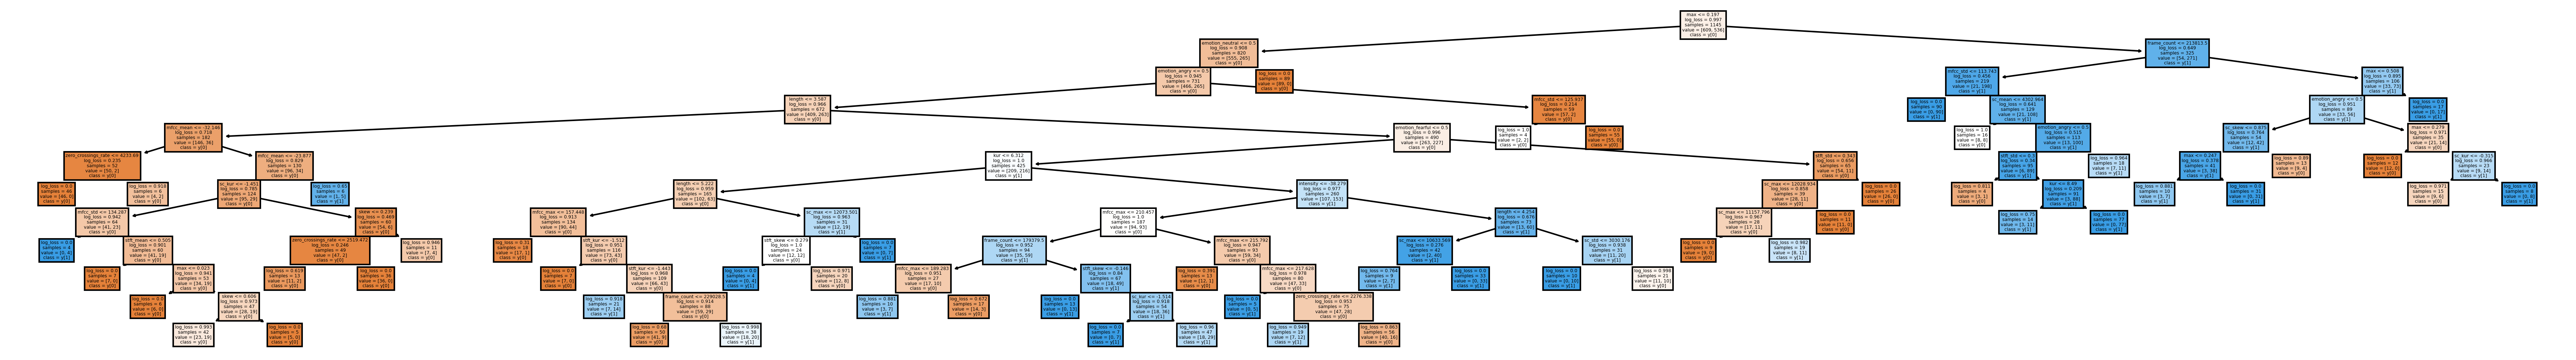

In [93]:
plt.figure(figsize=(30, 4), dpi=300)
plot_tree(dt, feature_names=df_ei.columns, class_names=True, filled=True)
plt.show()

In [94]:
dt.score(X_ei_train, y_ei_train)

0.8489082969432314

In [95]:
y_ei_train_pred = dt.predict(X_ei_train)
print(accuracy_score(y_ei_train, y_ei_train_pred))

0.8489082969432314


In [92]:
y_ei_train_pred, y_ei_train

(array(['normal', 'normal', 'normal', ..., 'normal', 'strong', 'strong'],
       dtype=object),
 array(['strong', 'normal', 'normal', ..., 'normal', 'strong', 'strong'],
       dtype=object))

In [96]:
y_ei_test_pred = dt.predict(X_ei_test)
print(accuracy_score(y_ei_test, y_ei_test_pred))
print(f1_score(y_ei_test, y_ei_test_pred, average="macro"))

0.6945010183299389
0.6911690707816169


In [97]:
print(classification_report(y_ei_test, y_ei_test_pred))

              precision    recall  f1-score   support

      normal       0.70      0.75      0.72       261
      strong       0.69      0.63      0.66       230

    accuracy                           0.69       491
   macro avg       0.69      0.69      0.69       491
weighted avg       0.69      0.69      0.69       491



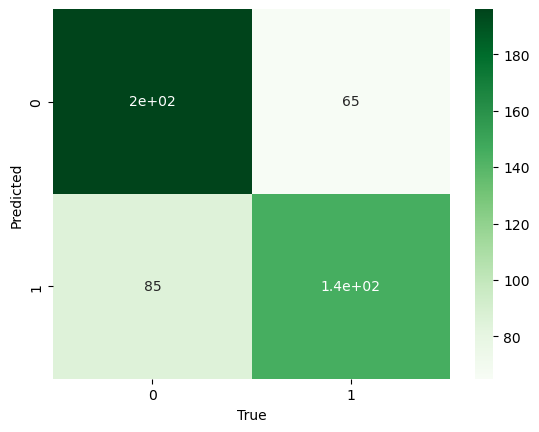

In [98]:
cf = confusion_matrix(y_ei_test, y_ei_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [99]:
y_ei_test_pred_proba = dt.predict_proba(X_ei_test)

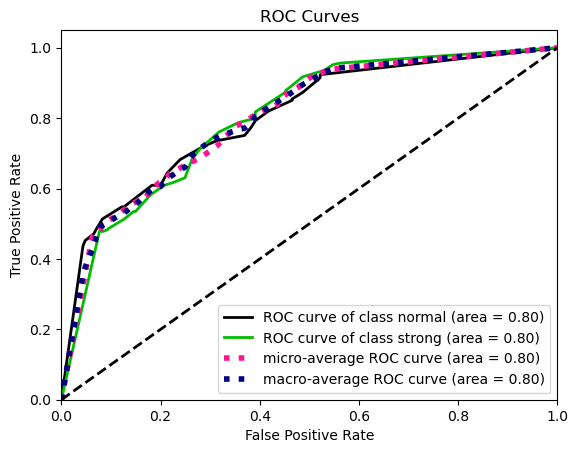

0.802023988005997


In [100]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
plot_roc(y_ei_test, dt.predict_proba(X_ei_test))
plt.show()
print(roc_auc_score(y_ei_test, y_ei_test_pred_proba[:,1], multi_class="ovr", average="macro"))

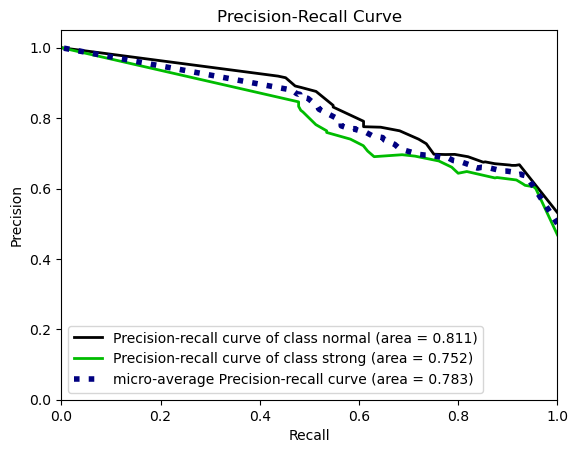

In [101]:
plot_precision_recall(y_ei_test, dt.predict_proba(X_ei_test))
plt.show()

#### changing criterions

In [102]:
%%time
param_grid = {
    "min_samples_split": loguniform(1e-2, 1e0),
    "min_samples_leaf": uniform(0.001, 0.2),
    "max_depth": randint(2, 200),
    "criterion": ["gini", "entropy", "log_loss"],
}
grid = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    n_iter=200,
)
grid.fit(X_ei_train, y_ei_train)
clf = grid.best_estimator_

Wall time: 34.3 s


In [103]:
print(grid.best_params_, grid.best_score_)

{'criterion': 'gini', 'max_depth': 32, 'min_samples_leaf': 0.02863099270786669, 'min_samples_split': 0.20481298870897757} 0.7402620087336245


In [104]:
clf.score(X_ei_test, y_ei_test)

0.7270875763747454

### Performance evaluation with the optimal parameters

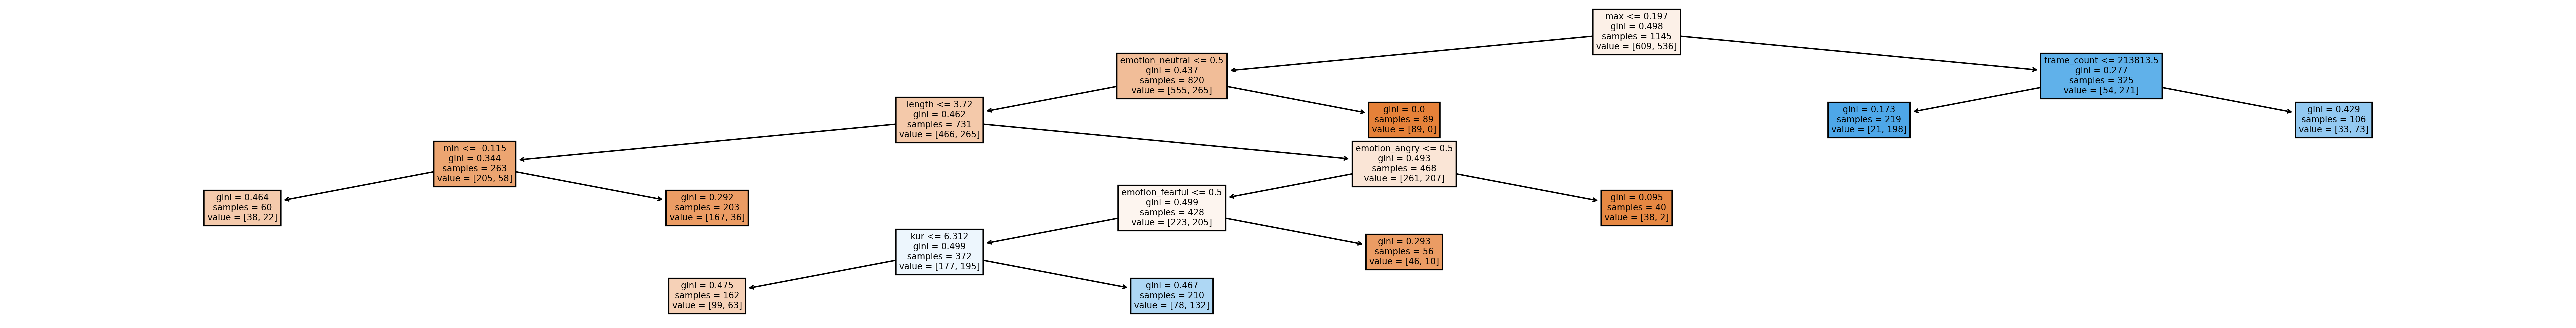

In [105]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=32, min_samples_split=0.2, min_samples_leaf=0.03)
dt.fit(X_ei_train, y_ei_train)
plt.figure(figsize=(33, 4), dpi=300)
plot_tree(dt, feature_names=df_ei.columns, filled=True)
plt.show()

In [106]:
y_ei_train_pred = dt.predict(X_ei_train)
print(accuracy_score(y_ei_train, y_ei_train_pred))

0.7685589519650655


In [107]:
y_ei_test_pred = dt.predict(X_ei_test)
print(accuracy_score(y_ei_test, y_ei_test_pred))
print(f1_score(y_ei_test, y_ei_test_pred, average="macro"))

0.7270875763747454
0.7262598189322327


In [108]:
print(classification_report(y_ei_test, y_ei_test_pred))

              precision    recall  f1-score   support

      normal       0.75      0.74      0.74       261
      strong       0.71      0.72      0.71       230

    accuracy                           0.73       491
   macro avg       0.73      0.73      0.73       491
weighted avg       0.73      0.73      0.73       491



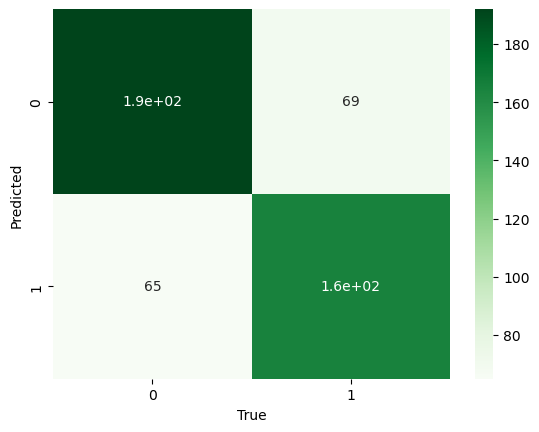

In [109]:
cf = confusion_matrix(y_ei_test, y_ei_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [110]:
y_ei_test_pred_proba = dt.predict_proba(X_ei_test)

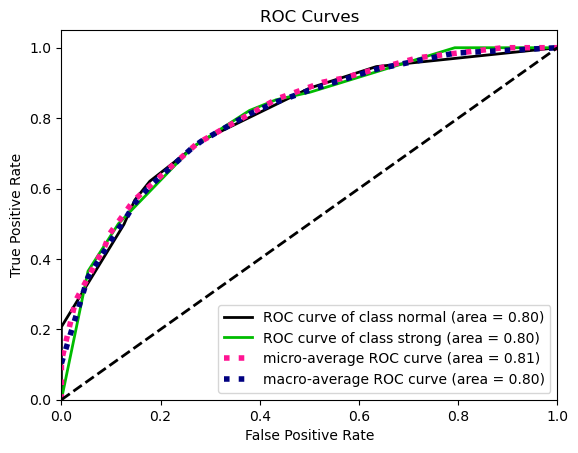

0.7998667333000167


In [111]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
plot_roc(y_ei_test, dt.predict_proba(X_ei_test))
plt.show()
print(roc_auc_score(y_ei_test, y_ei_test_pred_proba[:,1], multi_class="ovr", average="macro"))

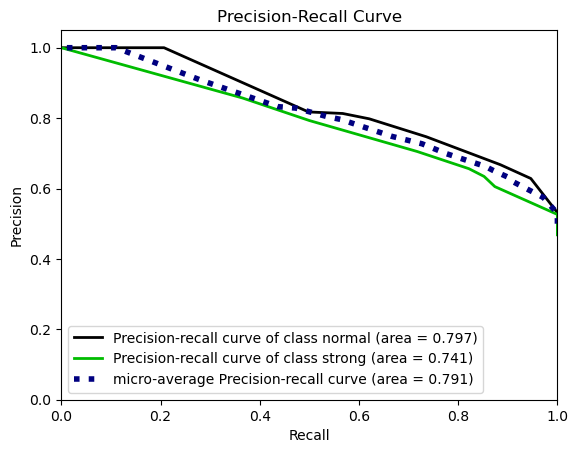

In [112]:
plot_precision_recall(y_ei_test, dt.predict_proba(X_ei_test))
plt.show()

# Decision trees to predict Emotion positivity

### Partition 

In [113]:
y_ep = np.array(df["emotion_positivity"]) # <--- this is the variable prediction parameter
df_ep = df.drop(columns = ["emotion_positivity","emotion"])
df_ep = pd.get_dummies(df_ep, columns=["emotional_intensity", "sex"])

In [117]:
df_ep.T

0              2              3     \
frame_count                 179379.000000  224224.000000  174575.000000   
intensity                      -36.793432     -32.290737     -49.019839   
mfcc_mean                      -33.485947     -30.532463     -36.059555   
mfcc_std                       134.654860     126.577110     159.725160   
mfcc_min                      -755.223450    -726.060360    -842.946350   
mfcc_max                       171.690920     165.456530     190.036090   
sc_mean                       5792.550744    4830.743037    5376.446478   
sc_std                        3328.055457    3332.131300    4053.663073   
sc_min                           0.000000       0.000000       0.000000   
sc_max                       13541.959028   12007.751173   12048.223893   
sc_kur                          -1.120769      -1.130153      -1.497765   
sc_skew                          0.250940       0.436699       0.098802   
stft_mean                        0.415250       0.379758       0.407277   
stft_std                         0.335533       0.352270       0.360552   
stft_min                         0.000000       0.000000       0.000000   
stft_kur                        -1.215025      -1.242947      -1.445318   
stft_skew                        0.403514       0.470350       0.274756   
std                              0.014482       0.024317       0.003561   
min                             -0.128632      -0.137482      -0.027374   
max                              0.138947       0.166351       0.024078   
kur                              9.406061       4.881241      13.040259   
skew                             0.273153       0.302659      -0.081014   
length                           3.737000       4.671000       3.637000   
zero_crossings_rate           4547.765587    4008.349390    3194.116030   
emotional_intensity_normal       1.000000       0.000000       1.000000   
emotional_intensity_strong       0.000000       1.000000       0.000000   
sex_F                            1.000000       1.000000       1.000000   
sex_M                            0.000000       0.000000       0.000000   
emotion_angry                    0.000000       0.000000       0.000000   
emotion_calm                     0.000000       0.000000       0.000000   
emotion_disgust                  0.000000       0.000000       0.000000   
emotion_fearful                  1.000000       0.000000       0.000000   
emotion_happy                    0.000000       1.000000       0.000000   
emotion_neutral                  0.000000       0.000000       0.000000   
emotion_sad                      0.000000       0.000000       0.000000   
emotion_surprised                0.000000       0.000000       1.000000   

                                     4              5              7     \
frame_count                 211411.000000  171371.000000  164965.000000   
intensity                      -31.214503     -36.312244     -49.095042   
mfcc_mean                      -31.405996     -30.500889     -36.048576   
mfcc_std                       122.125824     132.581730     167.652130   
mfcc_min                      -700.702760    -719.165470    -910.497440   
mfcc_max                       161.134000     213.681920     220.383730   
sc_mean                       5146.012474    4251.116912    6085.206268   
sc_std                        3442.724109    3833.178183    3737.829447   
sc_min                           0.000000       0.000000       0.000000   
sc_max                       12025.582707   12063.200741   12000.006162   
sc_kur                          -1.167544      -1.114527      -1.601514   
sc_skew                          0.496066       0.555198      -0.112737   
stft_mean                        0.415974       0.349669       0.487306   
stft_std                         0.350655       0.345256       0.328248   
stft_min                         0.000000       0.000000       0.000000   
stft_kur                        -1.366742      -1.098179     

In [114]:
X_ep = df_ep.values

In [115]:
X_ep_train, X_ep_test, y_ep_train, y_ep_test = train_test_split(
    X_ep, y_ep, test_size=0.3, stratify=y_ep, random_state=1
)

In [114]:
# with stratify
print(np.unique(y_ep, return_counts=True)[1] / len(y_ep))
print(np.unique(y_ep_train, return_counts=True)[1] / len(y_ep_train))
print(np.unique(y_ep_test, return_counts=True)[1] / len(y_ep_test))

[0.53789731 0.23227384 0.22982885]
[0.53799127 0.23231441 0.22969432]
[0.53767821 0.23217923 0.23014257]


In [116]:
print(X_ep_train.shape, X_ep_test.shape, y_ep_train.shape, y_ep_test.shape)

(1145, 28) (491, 28) (1145,) (491,)


### DT 

In [117]:
dt = DecisionTreeClassifier()

In [118]:
%%time
dt.fit(X_ep_train, y_ep_train)

Wall time: 25.4 ms


DecisionTreeClassifier()

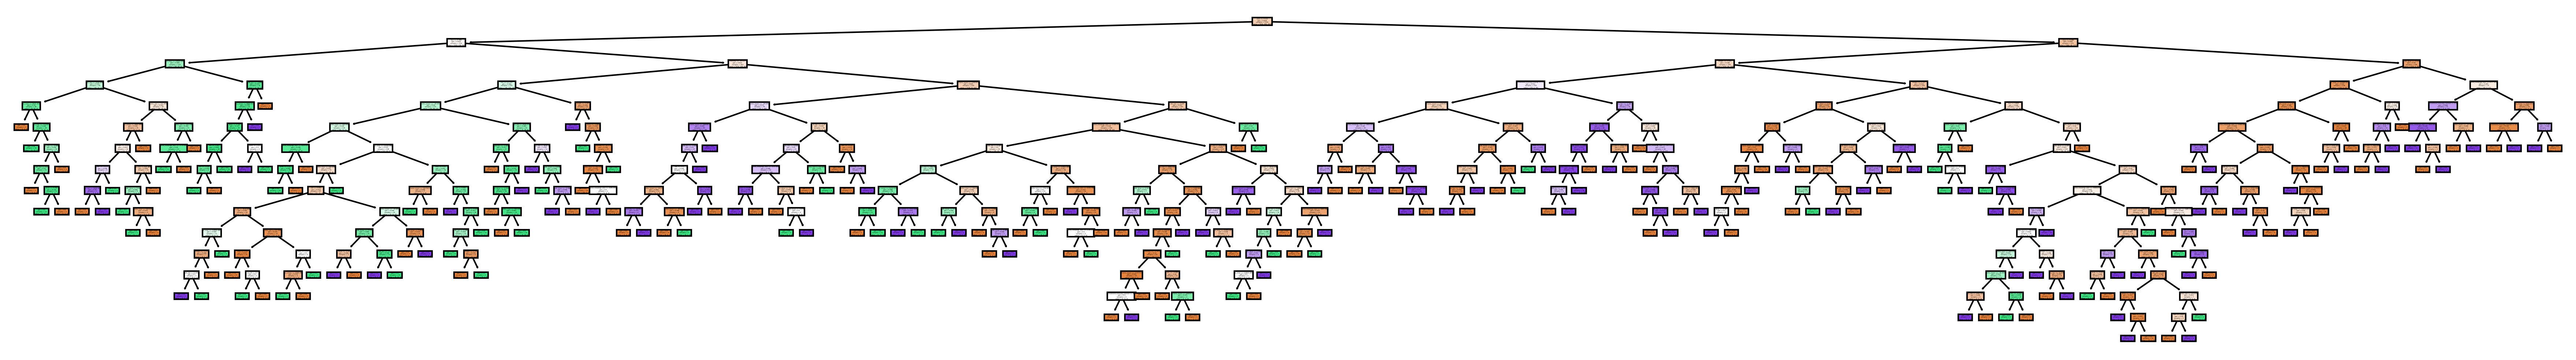

In [119]:
plt.figure(figsize=(30, 4), dpi=300)
plot_tree(dt, feature_names=df_ep.columns, filled=True)
plt.show()

In [120]:
dt.score(X_ep_train, y_ep_train)

1.0

### Performance evaluation

In [121]:
y_ep_train_pred = dt.predict(X_ep_train)
print(accuracy_score(y_ep_train, y_ep_train_pred))

1.0


In [121]:
y_ep_train_pred, y_ep_train

(array([-1, -1,  0, ..., -1, -1, -1], dtype=int64),
 array([-1, -1,  0, ..., -1, -1, -1], dtype=int64))

In [122]:
y_ep_test_pred = dt.predict(X_ep_test)
print(accuracy_score(y_ep_test, y_ep_test_pred))
print(f1_score(y_ep_test, y_ep_test_pred, average="macro"))

0.5519348268839104
0.5282214324767632


In [123]:
print(classification_report(y_ep_test, y_ep_test_pred))

              precision    recall  f1-score   support

          -1       0.66      0.58      0.62       264
           0       0.50      0.60      0.54       114
           1       0.41      0.44      0.42       113

    accuracy                           0.55       491
   macro avg       0.52      0.54      0.53       491
weighted avg       0.56      0.55      0.56       491



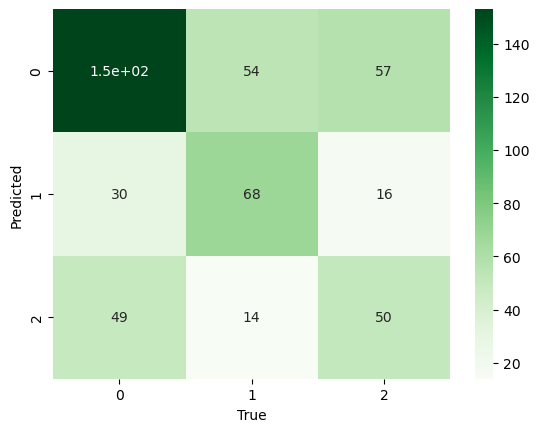

In [124]:
cf = confusion_matrix(y_ep_test, y_ep_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [125]:
y_ep_test_pred_proba = dt.predict_proba(X_ep_test)

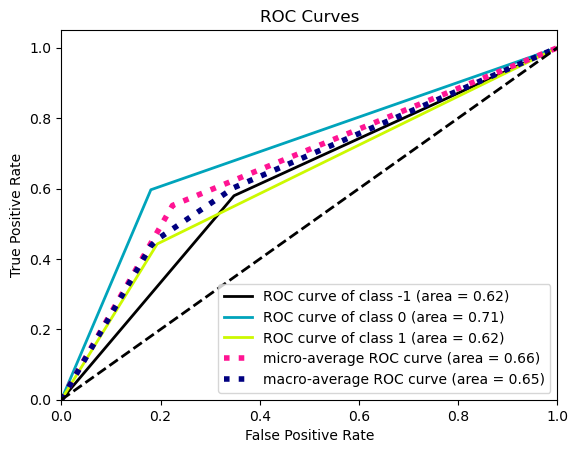

0.6495006486116018


In [126]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
plot_roc(y_ep_test, dt.predict_proba(X_ep_test))
plt.show()
print(roc_auc_score(y_ep_test, y_ep_test_pred_proba, multi_class="ovr", average="macro"))

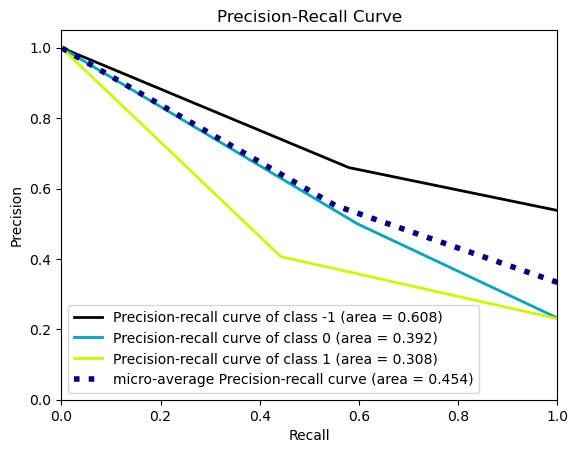

In [127]:
plot_precision_recall(y_ep_test, dt.predict_proba(X_ep_test))
plt.show()

### Cross-validation 

In [128]:
max_depth = 5
dt = DecisionTreeClassifier(max_depth=max_depth)
scores = cross_val_score(dt, X_ep_train, y_ep_train, cv=5)
cross_val_score(dt, X_ep_train, y_ep_train, cv=5)

array([0.65065502, 0.58951965, 0.60262009, 0.58078603, 0.5720524 ])

In [129]:
scores
#why the scores change in each iteration, 
#and scores and the last line of code of the previous cell are not the same?

array([0.65065502, 0.59388646, 0.6069869 , 0.58078603, 0.5720524 ])

### DT hyperparameters 

In [130]:
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std()))

Accuracy: 0.6009 (+/- 0.03)


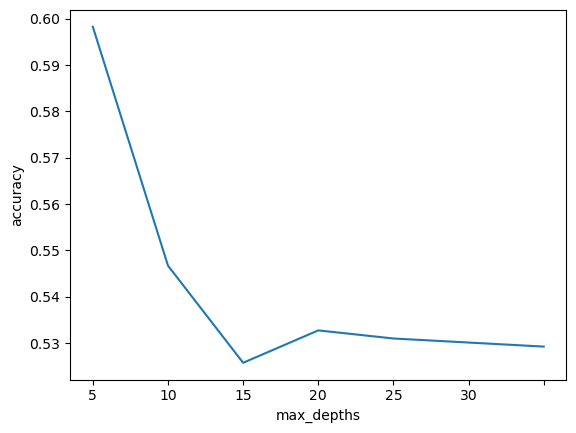

In [131]:
max_depths = [5, 10, 15, 20, 25, 30, None]
scores = list()
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    scores.append(cross_val_score(dt, X_ep_train, y_ep_train, cv=5).mean())
plt.plot(scores)
plt.xticks(range(len(max_depths)), max_depths)
plt.xlabel("max_depths")
plt.ylabel("accuracy")
plt.show()

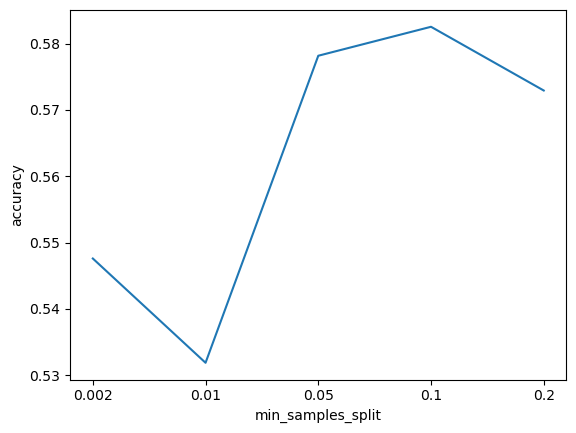

In [132]:
min_samples_splits = [0.002, 0.01, 0.05, 0.1, 0.2]
scores = list()
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    scores.append(cross_val_score(dt, X_ep_train, y_ep_train, cv=5).mean())
plt.plot(scores)
plt.xticks(range(len(min_samples_splits)), min_samples_splits)
plt.xlabel("min_samples_split")
plt.ylabel("accuracy")
plt.show()

### Grid Search

In [133]:
param_grid = {
    "min_samples_split": [0.002, 0.01, 0.05, 0.1, 0.2],
    "min_samples_leaf": [0.002, 0.01, 0.05, 0.1, 0.2],
    "max_depth": [5, 10, 15, 20, 25, 30, None],
}

grid = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0),
    n_jobs=-1,
    refit=True,
)

In [134]:
%%time
grid.fit(X_ep_train, y_ep_train)

Wall time: 36.5 s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20, 25, 30, None],
                         'min_samples_leaf': [0.002, 0.01, 0.05, 0.1, 0.2],
                         'min_samples_split': [0.002, 0.01, 0.05, 0.1, 0.2]})

In [135]:
clf = grid.best_estimator_

In [136]:
print(grid.best_params_, grid.best_score_)

{'max_depth': 5, 'min_samples_leaf': 0.05, 'min_samples_split': 0.002} 0.5663755458515284


In [137]:
clf.score(X_ep_test, y_ep_test)

0.570264765784114

#### changing criterions

In [138]:
%%time
param_grid = {
    "min_samples_split": loguniform(1e-2, 1e0),
    "min_samples_leaf": uniform(0.001, 0.2),
    "max_depth": randint(2, 200),
    "criterion": ["gini", "entropy", "log_loss"],
}
grid = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    n_iter=200,
)
grid.fit(X_ep_train, y_ep_train)
clf = grid.best_estimator_

Wall time: 37.2 s


In [139]:
print(grid.best_params_, grid.best_score_)

{'criterion': 'log_loss', 'max_depth': 178, 'min_samples_leaf': 0.04435909876375635, 'min_samples_split': 0.03976619033423752} 0.5669868995633188


In [140]:
clf.score(X_ep_test, y_ep_test)

0.5641547861507128

### Performance evaluation with the optimal parameters

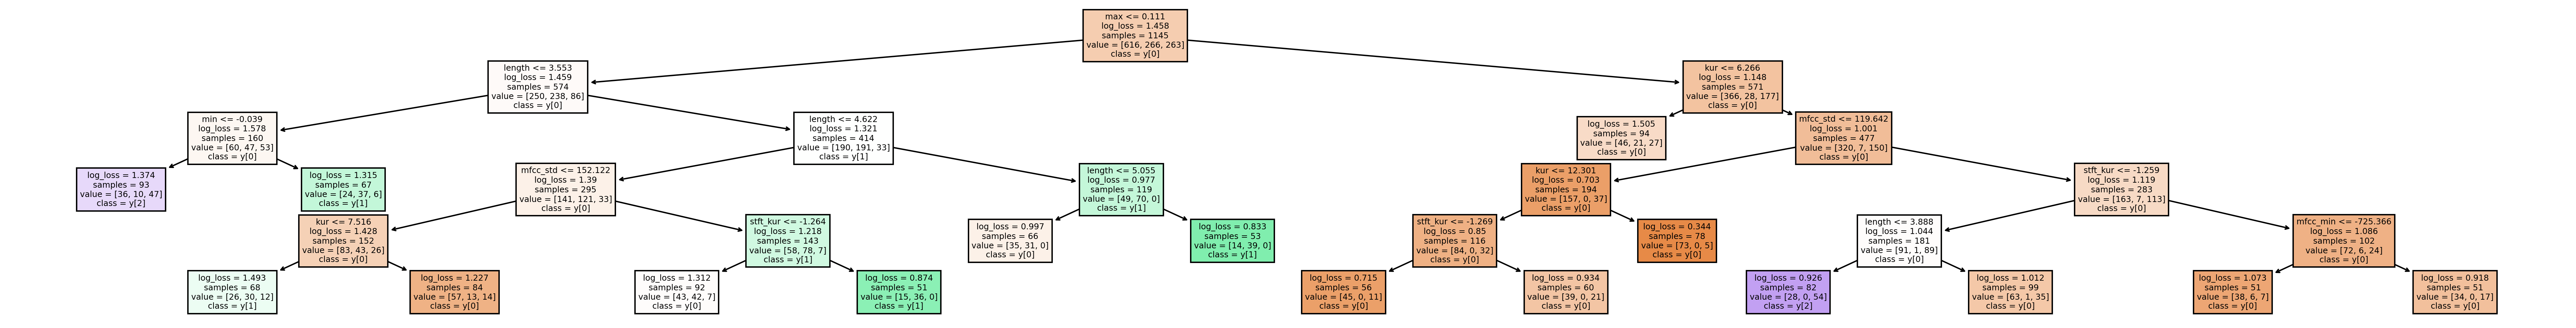

In [149]:
dt = DecisionTreeClassifier(criterion='log_loss', max_depth=178, min_samples_split=0.040, min_samples_leaf=0.044)
dt.fit(X_ep_train, y_ep_train)
plt.figure(figsize=(33, 4), dpi=300)
plot_tree(dt, feature_names=df_ep.columns, class_names= True, filled=True)
plt.show()

In [142]:
y_ep_train_pred = dt.predict(X_ep_train)
print(accuracy_score(y_ep_train, y_ep_train_pred))

0.6209606986899563


In [143]:
y_ep_test_pred = dt.predict(X_ep_test)
print(accuracy_score(y_ep_test, y_ep_test_pred))
print(f1_score(y_ep_test, y_ep_test_pred, average="macro"))

0.5845213849287169
0.5418578871092837


In [144]:
print(classification_report(y_ep_test, y_ep_test_pred))

              precision    recall  f1-score   support

          -1       0.64      0.66      0.65       264
           0       0.52      0.67      0.58       114
           1       0.50      0.32      0.39       113

    accuracy                           0.58       491
   macro avg       0.55      0.55      0.54       491
weighted avg       0.58      0.58      0.58       491



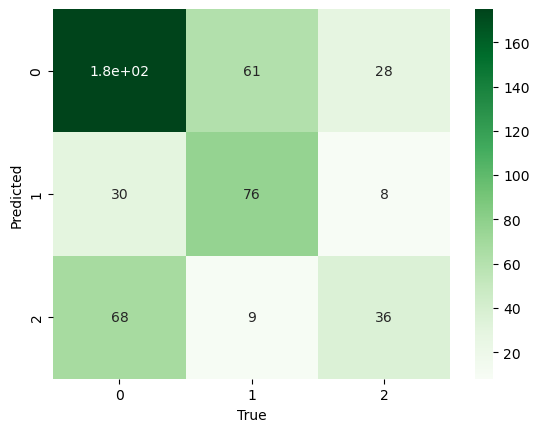

In [145]:
cf = confusion_matrix(y_ep_test, y_ep_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [ ]:
sns.heatmap(cf/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [146]:
y_ep_test_pred_proba = dt.predict_proba(X_ep_test)

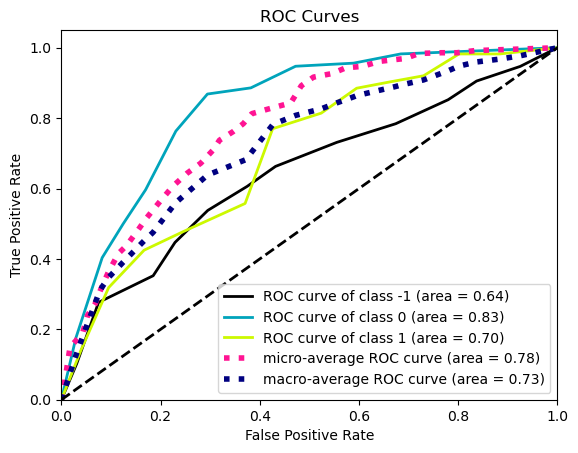

0.726029542236844


In [147]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
plot_roc(y_ep_test, dt.predict_proba(X_ep_test))
plt.show()
print(roc_auc_score(y_ep_test, y_ep_test_pred_proba, multi_class="ovr", average="macro"))

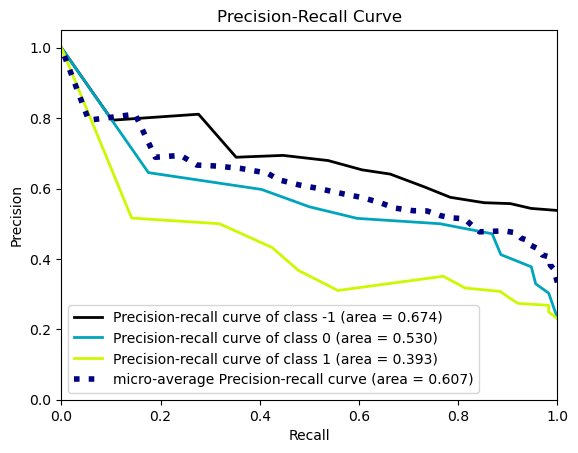

In [148]:
plot_precision_recall(y_ep_test, dt.predict_proba(X_ep_test))
plt.show()

# Pattern Mining with not normalized data

In [150]:
df_pmn = df.copy()

In [151]:
correlation_drop_cols = ["std", "mfcc_min", "max", "mfcc_std", "stft_skew", "min", "frame_count"]
df_pmn = df_pmn.drop(columns=correlation_drop_cols)

In [152]:
columns = df_pmn.columns.tolist()
delete = ["emotion","emotional_intensity","sex","emotion_positivity"]
n_clms = [ele for ele in columns if ele not in delete] #numerical columns

In [153]:
n_clms.remove('sc_min')
n_clms.remove('stft_min')

In [154]:
for v in n_clms:
    df_pmn[v+"_Bins"] = pd.qcut(df_pmn[v],4)

In [155]:
df_pmn["sc_min_Bins"] = pd.qcut(df_pmn["sc_min"].rank(method='first'),4)
df_pmn["stft_min_Bins"] = pd.qcut(df_pmn["stft_min"].rank(method='first'),4)

In [156]:
emposi_dict = {-1: "-1_emp", 0: "0_emp", 1: "1_emp"}
df_pmn["emo_positivityclass"] = df_pmn["emotion_positivity"].map(emposi_dict)

In [157]:
df_pmn.drop(n_clms, axis=1, inplace=True)

In [158]:
df_pmn.drop([ 'emotion_positivity','sc_min','stft_min'], axis=1, inplace=True)

In [282]:
df_pmn.T

0                     2     \
emotion                                 fearful                 happy   
emotional_intensity                      normal                strong   
sex                                           F                     F   
intensity_Bins               (-37.073, -31.591]    (-37.073, -31.591]   
mfcc_mean_Bins               (-42.117, -31.846]    (-31.846, -28.592]   
mfcc_max_Bins                  (126.25, 181.34]      (126.25, 181.34]   
sc_mean_Bins               (5757.813, 7655.336]    (4538.47, 5111.63]   
sc_std_Bins                (3023.334, 3431.139]  (3023.334, 3431.139]   
sc_max_Bins               (12082.584, 17477.54]  (12000.0, 12082.584]   
sc_kur_Bins                    (-1.313, -0.972]      (-1.313, -0.972]   
sc_skew_Bins                     (0.103, 0.356]        (0.356, 0.561]   
stft_mean_Bins                   (0.213, 0.415]        (0.213, 0.415]   
stft_std_Bins                    (0.334, 0.349]        (0.349, 0.392]   
stft_kur_Bins                  (-1.288, -1.154]      (-1.288, -1.154]   
kur_Bins                         (6.511, 9.786]        (2.297, 6.511]   
skew_Bins                          (0.263, 1.8]          (0.263, 1.8]   
length_Bins                      (3.604, 4.037]         (4.538, 6.34]   
zero_crossings_rate_Bins   (3635.066, 8130.602]  (3635.066, 8130.602]   
sc_min_Bins                     (0.999, 409.75]       (0.999, 409.75]   
stft_min_Bins                   (0.999, 409.75]       (0.999, 409.75]   
emo_positivityclass                      -1_emp                 1_emp   

                                                  3                     4     \
emotion                                      surprised                 happy   
emotional_intensity                             normal                strong   
sex                                                  F                     F   
intensity_Bins                       (-63.866, -43.54]    (-31.591, -16.354]   
mfcc_mean_Bins                      (-42.117, -31.846]    (-31.846, -28.592]   
mfcc_max_Bins                        (181.34, 201.879]      (126.25, 181.34]   
sc_mean_Bins                       (5111.63, 5757.813]   (5111.63, 5757.813]   
sc_std_Bins                       (3759.963, 4640.421]  (3431.139, 3759.963]   
sc_max_Bins                       (12000.0, 12082.584]  (12000.0, 12082.584]   
sc_kur_Bins                            (-1.791, -1.49]      (-1.313, -0.972]   
sc_skew_Bins                           (-0.511, 0.103]        (0.356, 0.561]   
stft_mean_Bins                          (0.213, 0.415]        (0.415, 0.474]   
stft_std_Bins                           (0.349, 0.392]        (0.349, 0.392]   
stft_kur_Bins             (-1.6709999999999998, -1.39]       (-1.39, -1.288]   
kur_Bins                               (9.786, 13.925]        (6.511, 9.786]   
skew_Bins                            (-0.34, -0.00424]          (0.263, 1.8]   
length_Bins                             (3.604, 4.037]        (4.037, 4.538]   
zero_crossings_rate_Bins          (3043.453, 3635.066]  (3043.453, 3635.066]   
sc_min_Bins                            (0.999, 409.75]       (0.999, 409.75]   
stft_min_Bins                          (0.999, 409.75]       (0.999, 409.75]   
emo_positivityclass                              1_emp                 1_emp   

                                                   5     \
emotion                                         fearful   
emotional_intensity                              normal   
sex                                                   F   
intensity_Bins                       (-37.073, -31.591]   
mfcc_mean_Bins                       (-31.846, -28.592]   
mfcc_max_Bins                        (201.879, 218.753]   
sc_mean_Bins              (2360.8799999999997, 4538.47]   
sc_std_Bins                        (3759.963, 4640.421]   
sc_max_Bins                        (12000.0, 12082.584]   
sc_kur_Bins                            (-1.313, -0.972]   
sc_skew_Bins              

In [159]:
n_clms.append('sc_min')
n_clms.append('stft_min')

In [160]:
n2_clms=df_pmn.columns.tolist()
n2_clms = n2_clms[3:-1]
len(n2_clms)== len(n_clms)

True

In [161]:
for i in range(len(n_clms)):
    df_pmn[n2_clms[i]] = df_pmn[n2_clms[i]].astype(str) + "_" + n_clms[i]
#df_pmn.T

In [162]:
X_n = df_pmn.values.tolist()

## Apriori 

In [29]:
help(apriori)

Help on built-in function apriori in module fim:

apriori(...)
    apriori (tracts, target='s', supp=10, zmin=1, zmax=None, report='a',
             eval='x', agg='x', thresh=10, prune=None, algo='b', mode='',
             border=None)
    Find frequent item sets with the Apriori algorithm.
    tracts  transaction database to mine (mandatory)
            The database must be an iterable of transactions;
            each transaction must be an iterable of items;
            each item must be a hashable object.
            If the database is a dictionary, the transactions are
            the keys, the values their (integer) multiplicities.
    target  type of frequent item sets to find     (default: s)
            s/a   sets/all   all     frequent item sets
            c     closed     closed  frequent item sets
            m     maximal    maximal frequent item sets
            g     gens       generators
            r     rules      association rules
    supp    minimum support of an i

## Frequen Itemset 

In [165]:
#supp = 2  # 2%
#supp = 20  # 20%
zmin = 2  # minimum number of items per item set

itemsets = apriori(X_n, target="s", supp=20, zmin=zmin, report="S")
fr_itemsets= pd.DataFrame(itemsets, columns=["frequent_itemset", "support"])
fr_itemsets

frequent_itemset    support
0              ((-31.591, -16.354]_intensity, strong)  20.232274
1                     ((1227.25, 1636.0]_stft_min, M)  24.572127
2                   ((-25.499, -15.552]_mfcc_mean, M)  20.721271
3                        ((0.241, 0.317]_stft_std, M)  23.044010
4                       ((0.528, 0.702]_stft_mean, M)  21.454768
5                       ((0.213, 0.415]_stft_mean, F)  22.677262
6                      ((126.25, 181.34]_mfcc_max, F)  22.616137
7                   ((-42.117, -31.846]_mfcc_mean, F)  22.188264
8   ((0.999, 409.75]_sc_min, (0.999, 409.75]_stft_...  25.000000
9                        ((0.349, 0.392]_stft_std, F)  22.004890
10                                        (strong, F)  22.493888
11                                        (strong, M)  24.327628
12                                   (strong, -1_emp)  27.322738
13                                        (F, normal)  25.794621
14                                        (F, -1_emp)  26.405868
15                                        (M, normal)  27.383863
16                                        (M, -1_emp)  27.383863
17                                   (normal, -1_emp)  26.466993

### Closed itemset

In [123]:
#supp = 2  # 2%
#supp = 20  # 20%
#zmin = 2  # minimum number of items per item set

itemsets = apriori(X_n, target="c", supp=27, zmin=zmin, report="S")
pd.DataFrame(itemsets, columns=["closed_itemset", "support"])

closed_itemset    support
0  (strong, -1_emp)  27.322738
1       (M, normal)  27.383863
2       (M, -1_emp)  27.383863

### Maximal itemsets

In [124]:
itemsets = apriori(X_n, target="m", supp=supp, zmin=zmin, report="S")
pd.DataFrame(itemsets, columns=["maximal_itemset", "support"])

maximal_itemset    support
0              ((-31.591, -16.354]_intensity, strong)  20.232274
1                     ((1227.25, 1636.0]_stft_min, M)  24.572127
2                   ((-25.499, -15.552]_mfcc_mean, M)  20.721271
3                        ((0.241, 0.317]_stft_std, M)  23.044010
4                       ((0.528, 0.702]_stft_mean, M)  21.454768
5                       ((0.213, 0.415]_stft_mean, F)  22.677262
6                      ((126.25, 181.34]_mfcc_max, F)  22.616137
7                   ((-42.117, -31.846]_mfcc_mean, F)  22.188264
8   ((0.999, 409.75]_sc_min, (0.999, 409.75]_stft_...  25.000000
9                        ((0.349, 0.392]_stft_std, F)  22.004890
10                                        (strong, F)  22.493888
11                                        (strong, M)  24.327628
12                                   (strong, -1_emp)  27.322738
13                                        (F, normal)  25.794621
14                                        (F, -1_emp)  26.405868
15                                        (M, normal)  27.383863
16                                        (M, -1_emp)  27.383863
17                                   (normal, -1_emp)  26.466993

The maximal itemsets are exactly the same closed itemsets

### Suport vs number of itemsets

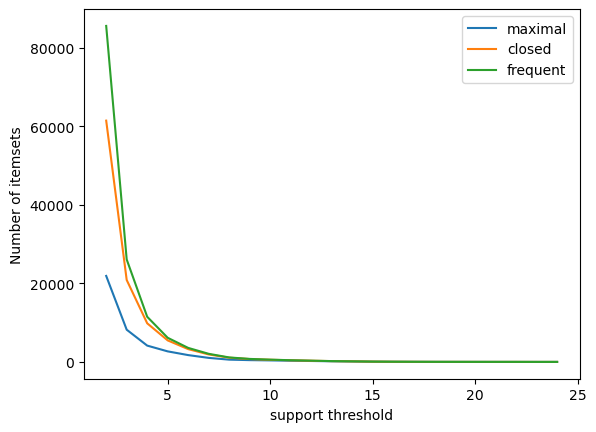

In [164]:
len_max_it = []
len_cl_it = []
len_fre_it = []
max_supp = 25
for i in range(2, max_supp):
    max_itemsets = apriori(X_n, target="m", supp=i, zmin=2)
    cl_itemsets = apriori(X_n, target="c", supp=i, zmin=2)
    fre_itemsets = apriori(X_n, target="s", supp=i, zmin=2)
    len_max_it.append(len(max_itemsets))
    len_cl_it.append(len(cl_itemsets))
    len_fre_it.append(len(fre_itemsets))

plt.plot(np.arange(2, max_supp), len_max_it, label="maximal")
plt.plot(np.arange(2, max_supp), len_cl_it, label="closed")
plt.plot(np.arange(2, max_supp), len_fre_it, label="frequent")
plt.legend()
plt.xlabel("support threshold")
plt.ylabel("Number of itemsets")

plt.show()

## Association rules extraction 

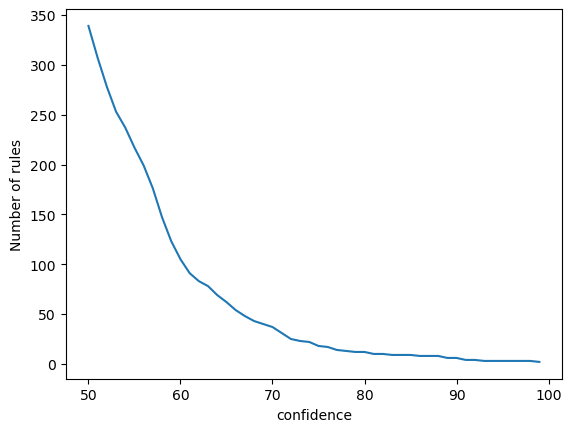

In [292]:
#confidence vs number of items
#This graphic can be helpful to decide which value of confidence to choose.
len_rules = []
max_conf = 100
for i in range(50, max_conf):
    rules = apriori(X_n, target="r", supp=20, zmin=zmin, conf=i, report="aScl")
    len_rules.append(len(rules))
plt.plot(np.arange(50, max_conf), len_rules)
plt.xlabel("confidence")
plt.ylabel("Number of rules")

plt.show()

### Trying with different values of confidence 

### conf = 85

In [382]:
conf = 85
rules = apriori(X_n, target="r", supp=20, zmin=2, conf=conf, report="aScl")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)
rules_df.sort_values(by="lift", axis=0, ascending=False)

consequent                       antecedent  abs_support  \
6  (0.999, 409.75]_stft_min        ((0.999, 409.75]_sc_min,)          409   
7    (0.999, 409.75]_sc_min      ((0.999, 409.75]_stft_min,)          409   
0                         M    ((1227.25, 1636.0]_stft_min,)          402   
3                         F      ((0.213, 0.415]_stft_mean,)          371   
4                         F     ((126.25, 181.34]_mfcc_max,)          370   
5                         F  ((-42.117, -31.846]_mfcc_mean,)          363   
8                         F       ((0.349, 0.392]_stft_std,)          360   
1                         M       ((0.241, 0.317]_stft_std,)          377   
2                         M      ((0.528, 0.702]_stft_mean,)          351   

   %_support  confidence      lift  
6  25.000000    1.000000  4.000000  
7  25.000000    1.000000  4.000000  
0  24.572127    0.982885  1.900709  
3  22.677262    0.907090  1.878481  
4  22.616137    0.904645  1.873418  
5  22.188264    0.887531  1.837975  
8  22.004890    0.880196  1.822785  
1  23.044010    0.921760  1.782506  
2  21.454768    0.858191  1.659574

In [170]:
rules_df['lift'] = rules_df['lift'].round(decimals = 4)

Text(0, 0.5, 'Frequency')

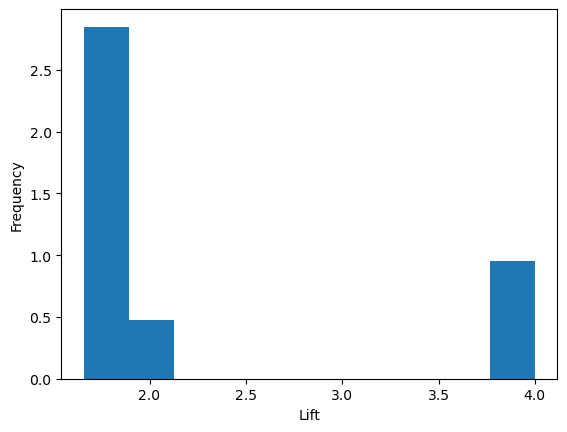

In [294]:
#rules' lift histogram
plt.hist(rules_df['lift'],density=True)
plt.xlabel("Lift")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

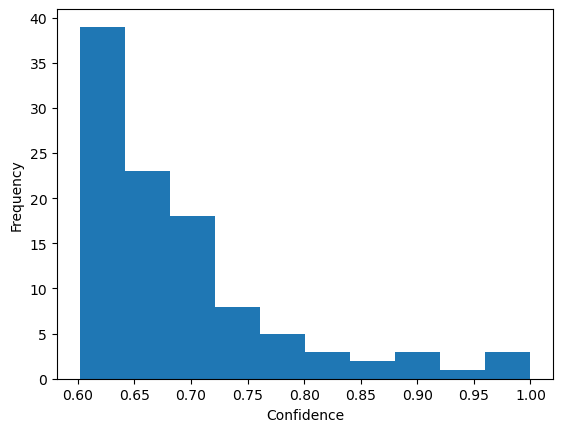

In [186]:
#rules' confidence histogram
plt.hist(rules_df['confidence'])
plt.xlabel("Confidence")
plt.ylabel("Frequency")

### conf = 90

In [295]:
conf = 90
rules = apriori(X_n, target="r", supp=20, zmin=zmin, conf=conf, report="aScl")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ]
)
rules_df.sort_values(by="lift", axis=0, ascending=False)

consequent                     antecedent  abs_support  \
4  (0.999, 409.75]_stft_min      ((0.999, 409.75]_sc_min,)          409   
5    (0.999, 409.75]_sc_min    ((0.999, 409.75]_stft_min,)          409   
0                         M  ((1227.25, 1636.0]_stft_min,)          402   
2                         F    ((0.213, 0.415]_stft_mean,)          371   
3                         F   ((126.25, 181.34]_mfcc_max,)          370   
1                         M     ((0.241, 0.317]_stft_std,)          377   

   %_support  confidence      lift  
4  25.000000    1.000000  4.000000  
5  25.000000    1.000000  4.000000  
0  24.572127    0.982885  1.900709  
2  22.677262    0.907090  1.878481  
3  22.616137    0.904645  1.873418  
1  23.044010    0.921760  1.782506

In [296]:
rules_df.style.hide_index()

C:\Users\Steffania\AppData\Local\Temp\ipykernel_26268\2139995904.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  rules_df.style.hide_index()


### conf = 95 

In [384]:
conf = 95
rules = apriori(X_n, target="r", supp=20, zmin=2, conf=conf, report="aScl")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)
rules_df.sort_values(by="lift", axis=0, ascending=False)

consequent                     antecedent  abs_support  \
1  (0.999, 409.75]_stft_min      ((0.999, 409.75]_sc_min,)          409   
2    (0.999, 409.75]_sc_min    ((0.999, 409.75]_stft_min,)          409   
0                         M  ((1227.25, 1636.0]_stft_min,)          402   

   %_support  confidence      lift  
1  25.000000    1.000000  4.000000  
2  25.000000    1.000000  4.000000  
0  24.572127    0.982885  1.900709

### conf = 100 

In [298]:
conf = 100
rules = apriori(X_n, target="r", supp=20, zmin=zmin, conf=conf, report="aScl")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)
rules_df.sort_values(by="lift", axis=0, ascending=False)

consequent                   antecedent  abs_support  \
0  (0.999, 409.75]_stft_min    ((0.999, 409.75]_sc_min,)          409   
1    (0.999, 409.75]_sc_min  ((0.999, 409.75]_stft_min,)          409   

   %_support  confidence  lift  
0       25.0         1.0   4.0  
1       25.0         1.0   4.0

### Confidence vs Lift 

In [166]:
conf = 50
rules = apriori(X_n, target="r", supp=20, zmin=zmin, conf=conf, report="aScl")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)
rules_df.sort_values(by="lift", axis=0, ascending=False)

consequent                                   antecedent  \
0                       happy                                     (1_emp,)   
1                        calm                                     (0_emp,)   
187  (0.999, 409.75]_stft_min                    ((0.999, 409.75]_sc_min,)   
186    (0.999, 409.75]_sc_min                  ((0.999, 409.75]_stft_min,)   
75    (0.241, 0.317]_stft_std                ((0.528, 0.702]_stft_mean, M)   
..                        ...                                          ...   
238                    normal               ((3023.334, 3431.139]_sc_std,)   
12                     -1_emp                      ((4.538, 6.34]_length,)   
145                    -1_emp  ((2599.744, 3043.453]_zero_crossings_rate,)   
284                    -1_emp     ((-1.6709999999999998, -1.39]_stft_kur,)   
307                    -1_emp                 ((0.349, 0.392]_stft_std, F)   

     abs_support  %_support  confidence      lift  
0            247  15.097800    0.656915  4.351064  
1            252  15.403423    0.663158  4.305263  
187          409  25.000000    1.000000  4.000000  
186          409  25.000000    1.000000  4.000000  
75           284  17.359413    0.809117  3.236467  
..           ...        ...         ...       ...  
238          205  12.530562    0.501222  0.942529  
12           196  11.980440    0.501279  0.931923  
145          205  12.530562    0.501222  0.931818  
284          205  12.530562    0.501222  0.931818  
307          180  11.002445    0.500000  0.929545  

[339 rows x 6 columns]

Text(0, 0.5, 'Lift')

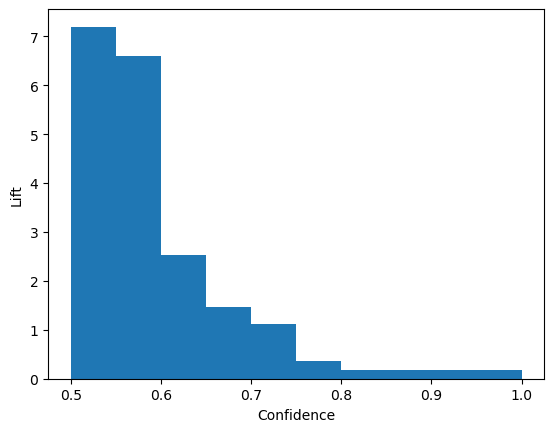

In [167]:
plt.hist(rules_df['confidence'],density=True)
plt.xlabel("Confidence")
plt.ylabel("Lift")

### Exploiting the association rules

The variables with missing values are actor, vocal channel, and intensity. 
With the associated rules found with confidence higher than 90% we can not replace missing values. I

In [168]:
conf = 50
rules = apriori(X_n, target="r", supp=20, zmin=zmin, conf=conf, report="aScl")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)
rules_df.sort_values(by="lift", axis=0, ascending=False)

consequent                                   antecedent  \
0                       happy                                     (1_emp,)   
1                        calm                                     (0_emp,)   
187  (0.999, 409.75]_stft_min                    ((0.999, 409.75]_sc_min,)   
186    (0.999, 409.75]_sc_min                  ((0.999, 409.75]_stft_min,)   
75    (0.241, 0.317]_stft_std                ((0.528, 0.702]_stft_mean, M)   
..                        ...                                          ...   
238                    normal               ((3023.334, 3431.139]_sc_std,)   
12                     -1_emp                      ((4.538, 6.34]_length,)   
145                    -1_emp  ((2599.744, 3043.453]_zero_crossings_rate,)   
284                    -1_emp     ((-1.6709999999999998, -1.39]_stft_kur,)   
307                    -1_emp                 ((0.349, 0.392]_stft_std, F)   

     abs_support  %_support  confidence      lift  
0            247  15.097800    0.656915  4.351064  
1            252  15.403423    0.663158  4.305263  
187          409  25.000000    1.000000  4.000000  
186          409  25.000000    1.000000  4.000000  
75           284  17.359413    0.809117  3.236467  
..           ...        ...         ...       ...  
238          205  12.530562    0.501222  0.942529  
12           196  11.980440    0.501279  0.931923  
145          205  12.530562    0.501222  0.931818  
284          205  12.530562    0.501222  0.931818  
307          180  11.002445    0.500000  0.929545  

[339 rows x 6 columns]

In [169]:
#rules_df[rules_df["consequent"].str.contains("emp")]

In [171]:
conf = 60
rules = apriori(X_n, target="r", supp=20, zmin=zmin, conf=conf, report="aScl")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)
rules_df.sort_values(by="lift", axis=0, ascending=False)

consequent                       antecedent  abs_support  \
0                       happy                         (1_emp,)          247   
1                        calm                         (0_emp,)          252   
72     (0.999, 409.75]_sc_min      ((0.999, 409.75]_stft_min,)          409   
73   (0.999, 409.75]_stft_min        ((0.999, 409.75]_sc_min,)          409   
24    (0.241, 0.317]_stft_std    ((0.528, 0.702]_stft_mean, M)          284   
..                        ...                              ...          ...   
60                     -1_emp          ((13.925, 59.086]_kur,)          251   
100                    normal     ((0.349, 0.392]_stft_std, F)          217   
93                     normal  ((-31.846, -28.592]_mfcc_mean,)          246   
83                     -1_emp       ((-1.313, -0.972]_sc_kur,)          247   
47                     -1_emp      ((1227.25, 1636.0]_sc_min,)          246   

     %_support  confidence      lift  
0    15.097800    0.656915  4.351064  
1    15.403423    0.663158  4.305263  
72   25.000000    1.000000  4.000000  
73   25.000000    1.000000  4.000000  
24   17.359413    0.809117  3.236467  
..         ...         ...       ...  
60   15.342298    0.613692  1.140909  
100  13.264059    0.602778  1.133499  
93   15.036675    0.601467  1.131034  
83   15.097800    0.603912  1.122727  
47   15.036675    0.601467  1.118182  

[105 rows x 6 columns]

In [370]:
print(rules_df[(rules_df["consequent"]=="F") &(rules_df["confidence"]>=0.80)]
)
print(rules_df[(rules_df["consequent"]=="M")&(rules_df["confidence"]>=0.80)])

consequent                       antecedent  abs_support  %_support  \
82           F      ((0.213, 0.415]_stft_mean,)          371  22.677262   
86           F     ((126.25, 181.34]_mfcc_max,)          370  22.616137   
91           F  ((-42.117, -31.846]_mfcc_mean,)          363  22.188264   
101          F       ((0.349, 0.392]_stft_std,)          360  22.004890   

     confidence      lift  
82     0.907090  1.878481  
86     0.904645  1.873418  
91     0.887531  1.837975  
101    0.880196  1.822785

consequent                       antecedent  abs_support  %_support  \
33          M      ((0.528, 0.702]_stft_mean,)          351  21.454768   
41          M    ((1227.25, 1636.0]_stft_min,)          402  24.572127   
55          M  ((-25.499, -15.552]_mfcc_mean,)          339  20.721271   
61          M       ((0.241, 0.317]_stft_std,)          377  23.044010   

    confidence      lift  
33    0.858191  1.659574  
41    0.982885  1.900709  
55    0.828851  1.602837  
61    0.921760  1.782506

In [353]:
print(rules_df[(rules_df["consequent"]=="F")&(rules_df["confidence"]>=0.90)].loc[82][1])
print(rules_df[(rules_df["consequent"]=="M")&(rules_df["confidence"]>=0.80)].loc[41][1])

('(0.213, 0.415]_stft_mean',)
('(1227.25, 1636.0]_stft_min',)


###  Predicting Sex: 

#### Using the datafram df_pmn that doesnt include the missing values of intensity 

##### Making the prediction 

In [172]:
rules_df[(rules_df["consequent"]=="F") &(rules_df["confidence"]>=0.80)]

consequent                       antecedent  abs_support  %_support  \
82           F      ((0.213, 0.415]_stft_mean,)          371  22.677262   
86           F     ((126.25, 181.34]_mfcc_max,)          370  22.616137   
91           F  ((-42.117, -31.846]_mfcc_mean,)          363  22.188264   
101          F       ((0.349, 0.392]_stft_std,)          360  22.004890   

     confidence      lift  
82     0.907090  1.878481  
86     0.904645  1.873418  
91     0.887531  1.837975  
101    0.880196  1.822785

In [173]:
rules_df[(rules_df["consequent"]=="M")&(rules_df["confidence"]>=0.80)]

consequent                       antecedent  abs_support  %_support  \
33          M      ((0.528, 0.702]_stft_mean,)          351  21.454768   
41          M    ((1227.25, 1636.0]_stft_min,)          402  24.572127   
55          M  ((-25.499, -15.552]_mfcc_mean,)          339  20.721271   
61          M       ((0.241, 0.317]_stft_std,)          377  23.044010   

    confidence      lift  
33    0.858191  1.659574  
41    0.982885  1.900709  
55    0.828851  1.602837  
61    0.921760  1.782506

In [174]:
print(df_pmn["stft_std_Bins"].value_counts())
print(df_pmn["stft_mean_Bins"].value_counts())
print(df_pmn["stft_min_Bins"].value_counts())
print(df_pmn["mfcc_mean_Bins"].value_counts())

(0.334, 0.349]_stft_std    409
(0.349, 0.392]_stft_std    409
(0.317, 0.334]_stft_std    409
(0.241, 0.317]_stft_std    409
Name: stft_std_Bins, dtype: int64
(0.213, 0.415]_stft_mean    409
(0.415, 0.474]_stft_mean    409
(0.474, 0.528]_stft_mean    409
(0.528, 0.702]_stft_mean    409
Name: stft_mean_Bins, dtype: int64
(0.999, 409.75]_stft_min      409
(409.75, 818.5]_stft_min      409
(1227.25, 1636.0]_stft_min    409
(818.5, 1227.25]_stft_min     409
Name: stft_min_Bins, dtype: int64
(-42.117, -31.846]_mfcc_mean    409
(-31.846, -28.592]_mfcc_mean    409
(-25.499, -15.552]_mfcc_mean    409
(-28.592, -25.499]_mfcc_mean    409
Name: mfcc_mean_Bins, dtype: int64


In [183]:
y_real = np.array(df_pmn["sex"])

In [185]:
#First prediction using only a rule to predict M
def prediction_sex(x):
    if(x == '(1227.25, 1636.0]_stft_min'):
        return 'M';
    return 'F';

y_pred0 = df_pmn["stft_min_Bins"].map(prediction_sex)

In [186]:
y_pred1 = []
for ind in df_pmn.index:
    if(df_pmn["stft_min_Bins"][ind] == '(1226.5, 1839.2]_stft_min') or (df_pmn["stft_std_Bins"][ind] == '(0.241, 0.317]_stft_std'):
        y_pred1.append('M')
    else:
        y_pred1.append('F')

In [187]:
y_pred2 = []
for ind in df_pmn.index:
    if(df_pmn["stft_min_Bins"][ind] == '(1226.5, 1839.2]_stft_min') or (df_pmn["stft_std_Bins"][ind] == '(0.241, 0.317]_stft_std') or (df_pmn["stft_mean_Bins"][ind] == '(0.528, 0.702]_stft_mean'):
        y_pred2.append('M')
    else:
        y_pred2.append('F')

In [188]:
#Using rules for M and F
y_pred3 = []
for ind in df_pmn.index:
    if(df_pmn["stft_min_Bins"][ind] == '(1226.5, 1839.2]_stft_min') or (df_pmn["stft_std_Bins"][ind] == '(0.241, 0.317]_stft_std') or (df_pmn["stft_mean_Bins"][ind] == '(0.528, 0.702]_stft_mean'):
        y_pred3.append('M')
    elif(df_pmn["stft_mean_Bins"][ind] == '(0.213, 0.415]_stft_mean'):
        y_pred3.append('F')
    else:
        y_pred3.append(0)
        

In [189]:
#Using rules for M and F
y_pred4 = []
for ind in df_pmn.index:
    if(df_pmn["stft_min_Bins"][ind] == '(1226.5, 1839.2]_stft_min') or (df_pmn["stft_std_Bins"][ind] == '(0.241, 0.317]_stft_std') or (df_pmn["stft_mean_Bins"][ind] == '(0.528, 0.702]_stft_mean'):
        y_pred4.append('M')
    elif(df_pmn["stft_mean_Bins"][ind] == '(0.213, 0.415]_stft_mean')  or (df_pmn["mfcc_max_Bins"][ind] == '(126.25, 181.34]_mfcc_max'):
        y_pred4.append('F')
    else:
        y_pred4.append(0)
        

In [190]:
#Using rules for M and F
y_pred5 = []
for ind in df_pmn.index:
    if(df_pmn["stft_min_Bins"][ind] == '(1226.5, 1839.2]_stft_min') or (df_pmn["stft_std_Bins"][ind] == '(0.241, 0.317]_stft_std') or (df_pmn["stft_mean_Bins"][ind] == '(0.528, 0.702]_stft_mean'):
        y_pred5.append('M')
    elif(df_pmn["stft_mean_Bins"][ind] == '(0.213, 0.415]_stft_mean')  or (df_pmn["mfcc_max_Bins"][ind] == '(126.25, 181.34]_mfcc_max') or (df_pmn["mfcc_mean_Bins"][ind] == '(-42.117, -31.846]_mfcc_mean'):
        y_pred5.append('F')
    else:
        y_pred5.append(0)
        

##### Measuring the performance of the prediction

In [191]:
print(accuracy_score(y_real, y_pred0))
print(f1_score(y_real, y_pred0, average="macro"))
print(classification_report(y_real, y_pred0))

0.7243276283618582
0.7085190225710939
              precision    recall  f1-score   support

           F       0.64      0.99      0.78       790
           M       0.98      0.48      0.64       846

    accuracy                           0.72      1636
   macro avg       0.81      0.73      0.71      1636
weighted avg       0.82      0.72      0.71      1636



In [192]:
print(accuracy_score(y_real, y_pred1))
print(f1_score(y_real, y_pred1, average="macro"))
print(classification_report(y_real, y_pred1))

0.6937652811735942
0.6762040583328559
              precision    recall  f1-score   support

           F       0.62      0.96      0.75       790
           M       0.92      0.45      0.60       846

    accuracy                           0.69      1636
   macro avg       0.77      0.70      0.68      1636
weighted avg       0.77      0.69      0.67      1636



In [193]:
print(accuracy_score(y_real, y_pred2))
print(f1_score(y_real, y_pred2, average="macro"))
print(classification_report(y_real, y_pred2))

0.7023227383863081
0.6945485215891121
              precision    recall  f1-score   support

           F       0.64      0.89      0.74       790
           M       0.84      0.52      0.65       846

    accuracy                           0.70      1636
   macro avg       0.74      0.71      0.69      1636
weighted avg       0.74      0.70      0.69      1636



In [194]:
print(accuracy_score(y_real, y_pred3))
print(f1_score(y_real, y_pred3, average="macro"))
print(classification_report(y_real, y_pred3))

0.4932762836185819
0.41897643097643095
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           F       0.91      0.46      0.61       790
           M       0.84      0.52      0.65       846

    accuracy                           0.49      1636
   macro avg       0.58      0.33      0.42      1636
weighted avg       0.87      0.49      0.63      1636



C:\Users\Steffania\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Steffania\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Steffania\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [195]:
print(accuracy_score(y_real, y_pred4))
print(f1_score(y_real, y_pred4, average="macro"))
print(classification_report(y_real, y_pred4))

0.5702933985330073
0.46001747201747206
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           F       0.90      0.62      0.73       790
           M       0.84      0.52      0.65       846

    accuracy                           0.57      1636
   macro avg       0.58      0.38      0.46      1636
weighted avg       0.87      0.57      0.69      1636



C:\Users\Steffania\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Steffania\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Steffania\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [196]:
print(accuracy_score(y_real, y_pred5))
print(f1_score(y_real, y_pred5, average="macro"))
print(classification_report(y_real, y_pred5))

0.628361858190709
0.4862075451804053
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           F       0.90      0.74      0.81       790
           M       0.84      0.52      0.65       846

    accuracy                           0.63      1636
   macro avg       0.58      0.42      0.49      1636
weighted avg       0.87      0.63      0.73      1636



C:\Users\Steffania\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Steffania\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Steffania\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Using the dataframe with the rows with missing values in intensity

In [197]:
df_pred = df_clean.copy()
df_pred = df_pred.drop(columns = ["actor", "channels", "frame_width","statement", "repetition","vocal_channel"])

In [198]:
correlation_drop_cols = ["std", "mfcc_min", "max", "mfcc_std", "stft_skew", "min", "frame_count"]
df_pred = df_pred.drop(columns=correlation_drop_cols)

In [199]:
columns = df_pred.columns.tolist()
delete = ["emotion","emotional_intensity","sex","emotion_positivity"]
n_clms = [ele for ele in columns if ele not in delete] #numerical columns

In [200]:
n_clms.remove('sc_min')
n_clms.remove('stft_min')

In [201]:
for v in n_clms:
    df_pred[v+"_Bins"] = pd.qcut(df_pred[v],4)

In [202]:
df_pred["sc_min_Bins"] = pd.qcut(df_pred["sc_min"].rank(method='first'),4)
df_pred["stft_min_Bins"] = pd.qcut(df_pred["stft_min"].rank(method='first'),4)

In [203]:
emposi_dict = {-1: "-1_emp", 0: "0_emp", 1: "1_emp"}
df_pred["emo_positivityclass"] = df_pred["emotion_positivity"].map(emposi_dict)

In [204]:
df_pred.drop(n_clms, axis=1, inplace=True)

In [205]:
df_pred.drop([ 'emotion_positivity','sc_min','stft_min'], axis=1, inplace=True)

In [326]:
df_pred.T

0                       1     \
emotion                                 fearful                   angry   
emotional_intensity                      normal                  normal   
sex                                           F                       F   
intensity_Bins               (-37.073, -31.591]                     NaN   
mfcc_mean_Bins               (-43.814, -31.829]      (-31.829, -28.681]   
mfcc_max_Bins                 (126.25, 180.081]      (201.697, 218.185]   
sc_mean_Bins                (5775.96, 7655.336]     (5122.712, 5775.96]   
sc_std_Bins                (3025.432, 3433.835]    (3768.503, 4819.783]   
sc_max_Bins               (12091.886, 17477.54]  (11516.034, 12000.293]   
sc_kur_Bins                    (-1.309, -0.983]        (-1.797, -1.496]   
sc_skew_Bins                    (0.0985, 0.348]         (0.0985, 0.348]   
stft_mean_Bins                   (0.213, 0.415]          (0.415, 0.476]   
stft_std_Bins                    (0.334, 0.349]          (0.349, 0.392]   
stft_kur_Bins                  (-1.292, -1.153]        (-1.391, -1.292]   
kur_Bins                          (6.52, 9.829]        (14.085, 59.086]   
skew_Bins                          (0.263, 1.8]            (0.263, 1.8]   
length_Bins                      (3.604, 4.004]          (3.604, 4.004]   
zero_crossings_rate_Bins   (3646.927, 8130.602]    (3040.051, 3646.927]   
sc_min_Bins                     (0.999, 613.75]         (0.999, 613.75]   
stft_min_Bins                   (0.999, 613.75]         (0.999, 613.75]   
emo_positivityclass                      -1_emp                  -1_emp   

                                                2     \
emotion                                        happy   
emotional_intensity                           strong   
sex                                                F   
intensity_Bins                    (-37.073, -31.591]   
mfcc_mean_Bins                    (-31.829, -28.681]   
mfcc_max_Bins                      (126.25, 180.081]   
sc_mean_Bins                    (4563.685, 5122.712]   
sc_std_Bins                     (3025.432, 3433.835]   
sc_max_Bins                   (12000.293, 12091.886]   
sc_kur_Bins                         (-1.309, -0.983]   
sc_skew_Bins                          (0.348, 0.557]   
stft_mean_Bins                        (0.213, 0.415]   
stft_std_Bins                         (0.349, 0.392]   
stft_kur_Bins                       (-1.292, -1.153]   
kur_Bins                  (1.7570000000000001, 6.52]   
skew_Bins                               (0.263, 1.8]   
length_Bins                           (4.538, 6.373]   
zero_crossings_rate_Bins        (3646.927, 8130.602]   
sc_min_Bins                          (0.999, 613.75]   
stft_min_Bins                        (0.999, 613.75]   
emo_positivityclass                            1_emp   

                                                   3     \
emotion                                       surprised   
emotional_intensity                              normal   
sex                                                   F   
intensity_Bins                        (-63.866, -43.54]   
mfcc_mean_Bins                       (-43.814, -31.829]   
mfcc_max_Bins                        (180.081, 201.697]   
sc_mean_Bins                        (5122.712, 5775.96]   
sc_std_Bins                        (3768.503, 4819.783]   
sc_max_Bins                      (12000.293, 12091.886]   
sc_kur_Bins                            (-1.797, -1.496]   
sc_skew_Bins                            (0.0985, 0.348]   
stft_mean_Bins                           (0.213, 0.415]   
stft_std_Bins                            (0.349, 0.392]   
stft_kur_Bins             (-1.6709999999999998, -1.391]   
kur_Bins                                (9.829, 14.085]   
skew_Bins                             (-0.337, 0.00426]   
length_Bins                              (3.604, 4.004]   
zero_crossings_rate_Bins           (3040.051, 3646.927]   
sc_min_Bins                           

In [206]:
n_clms.append('sc_min')

In [207]:
n_clms.append('stft_min')

In [208]:
n2_clms=df_pmn.columns.tolist()
n2_clms = n2_clms[3:-1]
len(n2_clms)== len(n_clms)

True

In [209]:
for i in range(len(n_clms)):
    df_pred[n2_clms[i]] = df_pred[n2_clms[i]].astype(str) + "_" + n_clms[i]
df_pred.T

0     \
emotion                                                    fearful   
emotional_intensity                                         normal   
sex                                                              F   
intensity_Bins                        (-37.073, -31.591]_intensity   
mfcc_mean_Bins                        (-43.814, -31.829]_mfcc_mean   
mfcc_max_Bins                           (126.25, 180.081]_mfcc_max   
sc_mean_Bins                           (5775.96, 7655.336]_sc_mean   
sc_std_Bins                            (3025.432, 3433.835]_sc_std   
sc_max_Bins                           (12091.886, 17477.54]_sc_max   
sc_kur_Bins                                (-1.309, -0.983]_sc_kur   
sc_skew_Bins                               (0.0985, 0.348]_sc_skew   
stft_mean_Bins                            (0.213, 0.415]_stft_mean   
stft_std_Bins                              (0.334, 0.349]_stft_std   
stft_kur_Bins                            (-1.292, -1.153]_stft_kur   
kur_Bins                                         (6.52, 9.829]_kur   
skew_Bins                                        (0.263, 1.8]_skew   
length_Bins                                  (3.604, 4.004]_length   
zero_crossings_rate_Bins  (3646.927, 8130.602]_zero_crossings_rate   
sc_min_Bins                                 (0.999, 613.75]_sc_min   
stft_min_Bins                             (0.999, 613.75]_stft_min   
emo_positivityclass                                         -1_emp   

                                                              1     \
emotion                                                      angry   
emotional_intensity                                         normal   
sex                                                              F   
intensity_Bins                                       nan_intensity   
mfcc_mean_Bins                        (-31.829, -28.681]_mfcc_mean   
mfcc_max_Bins                          (201.697, 218.185]_mfcc_max   
sc_mean_Bins                           (5122.712, 5775.96]_sc_mean   
sc_std_Bins                            (3768.503, 4819.783]_sc_std   
sc_max_Bins                          (11516.034, 12000.293]_sc_max   
sc_kur_Bins                                (-1.797, -1.496]_sc_kur   
sc_skew_Bins                               (0.0985, 0.348]_sc_skew   
stft_mean_Bins                            (0.415, 0.476]_stft_mean   
stft_std_Bins                              (0.349, 0.392]_stft_std   
stft_kur_Bins                            (-1.391, -1.292]_stft_kur   
kur_Bins                                      (14.085, 59.086]_kur   
skew_Bins                                        (0.263, 1.8]_skew   
length_Bins                                  (3.604, 4.004]_length   
zero_crossings_rate_Bins  (3040.051, 3646.927]_zero_crossings_rate   
sc_min_Bins                                 (0.999, 613.75]_sc_min   
stft_min_Bins                             (0.999, 613.75]_stft_min   
emo_positivityclass                                         -1_emp   

                                                              2     \
emotion                                                      happy   
emotional_intensity                                         strong   
sex                                                              F   
intensity_Bins                        (-37.073, -31.591]_intensity   
mfcc_mean_Bins                        (-31.829, -28.681]_mfcc_mean   
mfcc_max_Bins                           (126.25, 180.081]_mfcc_max   
sc_mean_Bins                          (4563.685, 5122.712]_sc_mean   
sc_std_Bins                            (3025.432, 3433.835]_sc_std   
sc_max_Bins                          (12000.293, 12091.886]_sc_max   
sc_kur_Bins                                (-1.309, -0.983]_sc_kur   
sc_skew_Bins                                (0.348, 0.557]_sc_skew   
stft_mean_Bins                            (0.213, 0.415]_stft_mean   
stft_std_Bins                              (0.349, 0.392]_stft_std   


In [210]:
print(df_pred["stft_std_Bins"].value_counts())
print(df_pred["stft_mean_Bins"].value_counts())
print(df_pred["mfcc_mean_Bins"].value_counts())

(0.334, 0.349]_stft_std    613
(0.349, 0.392]_stft_std    613
(0.318, 0.334]_stft_std    613
(0.209, 0.318]_stft_std    613
Name: stft_std_Bins, dtype: int64
(0.213, 0.415]_stft_mean    613
(0.415, 0.476]_stft_mean    613
(0.476, 0.531]_stft_mean    613
(0.531, 0.724]_stft_mean    613
Name: stft_mean_Bins, dtype: int64
(-43.814, -31.829]_mfcc_mean    613
(-31.829, -28.681]_mfcc_mean    613
(-25.55, -15.491]_mfcc_mean     613
(-28.681, -25.55]_mfcc_mean     613
Name: mfcc_mean_Bins, dtype: int64


##### Making the prediction 

In [370]:
rules_df[(rules_df["consequent"]=="F") &(rules_df["confidence"]>=0.80)]

consequent                       antecedent  abs_support  %_support  \
82           F      ((0.213, 0.415]_stft_mean,)          371  22.677262   
86           F     ((126.25, 181.34]_mfcc_max,)          370  22.616137   
91           F  ((-42.117, -31.846]_mfcc_mean,)          363  22.188264   
101          F       ((0.349, 0.392]_stft_std,)          360  22.004890   

     confidence      lift  
82     0.907090  1.878481  
86     0.904645  1.873418  
91     0.887531  1.837975  
101    0.880196  1.822785

In [354]:
rules_df[(rules_df["consequent"]=="M")&(rules_df["confidence"]>=0.80)]

consequent                       antecedent  abs_support  %_support  \
33          M      ((0.528, 0.702]_stft_mean,)          351  21.454768   
41          M    ((1227.25, 1636.0]_stft_min,)          402  24.572127   
55          M  ((-25.499, -15.552]_mfcc_mean,)          339  20.721271   
61          M       ((0.241, 0.317]_stft_std,)          377  23.044010   

    confidence      lift  
33    0.858191  1.659574  
41    0.982885  1.900709  
55    0.828851  1.602837  
61    0.921760  1.782506

In [211]:
y_real1 = np.array(df_pred["sex"])

In [212]:
def prediction_sex(x):
    if(x == '(1227.25, 1636.0]_stft_min'):
        return 'M';
    return 'F';

y_pred6 = df_pred["stft_min_Bins"].map(prediction_sex)

In [213]:
y_pred7 = []
for ind in df_pred.index:
    if(df_pred["stft_min_Bins"][ind] == '(1226.5, 1839.2]_stft_min') or (df_pred["stft_mean_Bins"][ind] == '(0.531, 0.724]_stft_mean') or (df_pred["mfcc_mean_Bins"][ind] == '(-25.55, -15.491]_mfcc_mean'):
        y_pred7.append('M')
    elif(df_pred["stft_mean_Bins"][ind] == '(0.213, 0.415]_stft_mean') or (df_pred["stft_std_Bins"][ind] == '(0.349, 0.392]_stft_std') or (df_pred["mfcc_mean_Bins"][ind] == '(-43.814, -31.829]_mfcc_mean'):
        y_pred7.append('F')
    else:
        y_pred7.append(0)
        

##### Measuring the performance of the prediction

In [215]:
print(accuracy_score(y_real1, y_pred6))
print(f1_score(y_real1, y_pred6, average="macro"))
print(classification_report(y_real1, y_pred6))

0.4910277324632953
0.3293216630196937
              precision    recall  f1-score   support

           F       0.49      1.00      0.66      1204
           M       0.00      0.00      0.00      1248

    accuracy                           0.49      2452
   macro avg       0.25      0.50      0.33      2452
weighted avg       0.24      0.49      0.32      2452



C:\Users\Steffania\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Steffania\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Steffania\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [216]:
print(accuracy_score(y_real1, y_pred7))
print(f1_score(y_real1, y_pred7, average="macro"))
print(classification_report(y_real1, y_pred7))

0.6929037520391517
0.5106668306652341
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           F       0.89      0.68      0.77      1204
           M       0.82      0.71      0.76      1248

    accuracy                           0.69      2452
   macro avg       0.57      0.46      0.51      2452
weighted avg       0.86      0.69      0.77      2452



C:\Users\Steffania\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Steffania\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Steffania\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
